C:\Users\user\AppData\Local\Temp\ipykernel_10908\426315618.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(df["ds"].min(), df["ds"].max(), freq="H")
03:25:30 - cmdstanpy - INFO - Chain [1] start processing
03:25:30 - cmdstanpy - INFO - Chain [1] done processing
03:25:31 - cmdstanpy - INFO - Chain [1] start processing
03:25:32 - cmdstanpy - INFO - Chain [1] done processing
03:25:33 - cmdstanpy - INFO - Chain [1] start processing
03:25:34 - cmdstanpy - INFO - Chain [1] done processing
03:25:35 - cmdstanpy - INFO - Chain [1] start processing
03:25:35 - cmdstanpy - INFO - Chain [1] done processing
03:25:36 - cmdstanpy - INFO - Chain [1] start processing
03:25:36 - cmdstanpy - INFO - Chain [1] done processing
03:25:37 - cmdstanpy - INFO - Chain [1] start processing
03:25:38 - cmdstanpy - INFO - Chain [1] done processing
03:25:39 - cmdstanpy - INFO - Chain [1] start processing
03:25:40 - cmdstanpy - INFO - 


Daily metrics (last 30 days)
           Date    MAE     RMSE           R2
0   2025-04-08   6.56   123.79         0.88
1   2025-04-09   5.98   104.43         0.70
2   2025-04-10   8.43   143.90         0.85
3   2025-04-11   6.08    92.70         0.80
4   2025-04-12   4.39    31.74  -4650333.23
5   2025-04-13   4.38    31.36 -12346259.80
6   2025-04-14   6.42    91.97         0.80
7   2025-04-15   3.39    28.50         0.96
8   2025-04-16   4.03    50.20         0.87
9   2025-04-17   5.71   103.18         0.83
10  2025-04-18   5.92    95.72         0.29
11  2025-04-19   4.58    31.67  -3881187.68
12  2025-04-20   4.56    31.32  -5016883.14
13  2025-04-21   4.57    31.10  -8485911.09
14  2025-04-22  20.45   685.88         0.62
15  2025-04-23   5.47    76.88         0.90
16  2025-04-24   5.94    83.69         0.87
17  2025-04-25  12.30   360.62         0.53
18  2025-04-26   4.33    31.24  -3318601.67
19  2025-04-27   4.31    30.89  -3802462.57
20  2025-04-28  23.15  1406.20         0.12
2

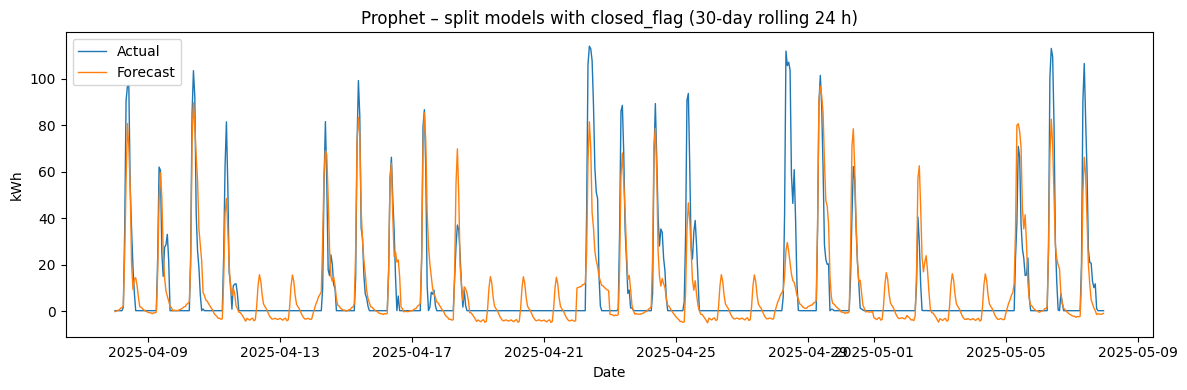

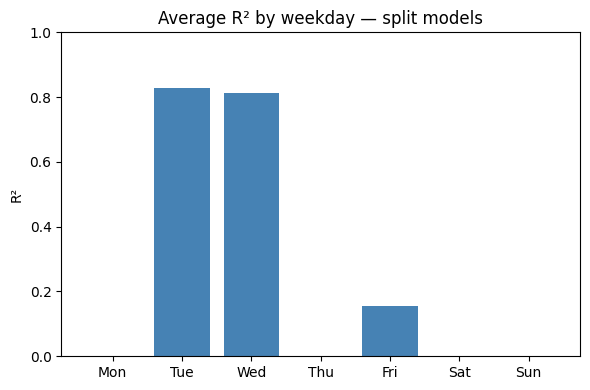

In [29]:
"""
Prophet back-test with hard “closed” logic
-----------------------------------------

Key upgrades
------------
1. **closed_flag**  = 1 on Saturdays, Sundays **or** Belgian public holidays  
   • passed to Prophet in *additive* mode → lets model learn a negative offset  
2. **Lag columns zeroed** whenever closed_flag == 1  
   • prevents Friday’s big lag24 from polluting Saturday  
3. Two separate models  
   • **Open-day model**  (Mon-Fri, non-holiday) – keeps 24-h lag, work-hours dummy  
   • **Closed-day model** (weekends + holidays) – uses only 168-h lag  
4. Rolling 30-day 24-h forecast with MAE/RMSE/R², plus plots
"""

# ------------------------------------------------------------------
# 0. imports
# ------------------------------------------------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import date, timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30

# ------------------------------------------------------------------
# 1. load & assert hourly cadence
# ------------------------------------------------------------------
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .sort_values("Date")
        .rename(columns={"Date": "ds", "Chargers": "y"})
        .reset_index(drop=True))

full_index = pd.date_range(df["ds"].min(), df["ds"].max(), freq="H")
#assert len(full_index) == len(df), "Input has missing hours!"

# ------------------------------------------------------------------
# 2. holiday + terugkomdagen dataframe
# ------------------------------------------------------------------
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]

holidays_df = pd.concat(
    [
        pd.DataFrame({"ds": pd.to_datetime(be_holidays),   "holiday": "be_holiday"}),
        pd.DataFrame({"ds": pd.to_datetime(terugkomdagen), "holiday": "back_to_work"}),
    ],
    ignore_index=True,
)

holiday_dates = set(pd.to_datetime(be_holidays).date)

# ------------------------------------------------------------------
# 3. fleet-size step curve (with fallback)
# ------------------------------------------------------------------
fleet_steps = {
    "2024-06-20": 35, "2024-06-25": 36, "2024-09-05": 38, "2024-09-12": 41,
    "2024-09-27": 42, "2024-10-15": 43, "2024-10-29": 45, "2024-11-05": 46,
    "2024-11-26": 47, "2025-01-09": 48, "2025-01-23": 49, "2025-01-28": 50,
    "2025-02-04": 51,
}
step_list = sorted([(pd.to_datetime(k), v) for k, v in fleet_steps.items()])
DEFAULT_FLEET = 35


def fleet_at(ts):
    vals = [v for d, v in step_list if d <= ts]
    return max(vals) if vals else DEFAULT_FLEET


df["fleet_size"] = df["ds"].apply(fleet_at)

# ------------------------------------------------------------------
# 4. engineered regressors
# ------------------------------------------------------------------
df["weekday"]     = df["ds"].dt.weekday
df["is_weekend"]  = (df["weekday"] >= 5).astype(int)
df["is_holiday"]  = df["ds"].dt.date.isin(holiday_dates).astype(int)
df["closed_flag"] = ((df["is_weekend"] == 1) | (df["is_holiday"] == 1)).astype(int)
df["work_hours"]  = df["ds"].dt.hour.between(7, 18).astype(int)

# lag features
df["lag24_kWh"]   = df["y"].shift(24)
df["lag168_kWh"]  = df["y"].shift(168)

bev_now           = np.floor(df["y"] / 10.0)
phev_flag         = ((df["y"] % 10) > 0).astype(int)

df["lag24_bev"]   = bev_now.shift(24)
df["lag24_phev"]  = phev_flag.shift(24)
df["lag168_bev"]  = bev_now.shift(168)
df["lag168_phev"] = phev_flag.shift(168)

# zero-out lag columns for closed hours
lag_cols = [
    "lag24_kWh", "lag24_bev", "lag24_phev",
    "lag168_kWh", "lag168_bev", "lag168_phev",
]
df.loc[df["closed_flag"] == 1, lag_cols] = 0

df = df.dropna().reset_index(drop=True)  # first 168 h removed

# ------------------------------------------------------------------
# 5. select last 30 complete days
# ------------------------------------------------------------------
all_days = sorted(df["ds"].dt.date.unique())
test_days = []
ptr = all_days[-2]
while len(test_days) < BACKTEST_DAYS:
    if (df["ds"].dt.date == ptr).sum() == 24:
        test_days.append(ptr)
    ptr -= timedelta(days=1)
test_days = sorted(test_days)

# ------------------------------------------------------------------
# 6. Prophet builder helpers
# ------------------------------------------------------------------
def build_open_model():
    m = Prophet(
        holidays=holidays_df,
        weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False,
    )
    m.add_seasonality("daily", period=1, fourier_order=8)
    m.add_seasonality("weekly", period=7, fourier_order=6)
    m.add_seasonality("monthly", period=30.5, fourier_order=5)

    add_regs = [
        "fleet_size",
        "lag24_kWh",
        "lag168_kWh",
        "lag24_bev",
        "lag24_phev",
        "work_hours",
        "closed_flag",
    ]
    for col in add_regs[:-1]:
        m.add_regressor(col)  # additive (default)
    m.add_regressor("closed_flag", mode="additive")
    return m


def build_closed_model():
    m = Prophet(
        holidays=holidays_df,
        weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False,
    )
    m.add_seasonality("daily", period=1, fourier_order=6)
    m.add_regressor("fleet_size")
    for col in ["lag168_kWh", "lag168_bev", "lag168_phev", "closed_flag"]:
        m.add_regressor(col)
    return m


# ------------------------------------------------------------------
# 7. walk-forward back-test
# ------------------------------------------------------------------
results, pred_frames = [], []

for day in test_days:
    mask_train = df["ds"].dt.date < day
    mask_test  = df["ds"].dt.date == day
    train, test = df[mask_train].copy(), df[mask_test].copy()

    if test["closed_flag"].iloc[0] == 1:
        mdl = build_closed_model()
        cols = ["ds", "y", "fleet_size", "lag168_kWh",
                "lag168_bev", "lag168_phev", "closed_flag"]
    else:
        mdl = build_open_model()
        cols = ["ds", "y", "fleet_size", "lag24_kWh", "lag168_kWh",
                "lag24_bev", "lag24_phev", "work_hours", "closed_flag"]

    mdl.fit(train[cols])
    fut = test[cols].drop(columns="y")
    yhat = mdl.predict(fut)["yhat"].values

    mae = mean_absolute_error(test["y"], yhat)
    rmse = mean_squared_error(test["y"], yhat)
    r2 = r2_score(test["y"], yhat)

    results.append({"Date": day, "MAE": mae, "RMSE": rmse, "R2": r2})

    tmp = test[["ds", "y"]].rename(columns={"y": "Actual"})
    tmp["Forecast"] = yhat
    pred_frames.append(tmp)

# ------------------------------------------------------------------
# 8. metrics & plots
# ------------------------------------------------------------------
res_df = pd.DataFrame(results).round(2)
print("\nDaily metrics (last 30 days)\n", res_df)
print("\nAverages\n", res_df[["MAE", "RMSE", "R2"]].mean().round(2))

full = pd.concat(pred_frames).sort_values("ds")
plt.figure(figsize=(12, 4))
plt.plot(full["ds"], full["Actual"], label="Actual", lw=1)
plt.plot(full["ds"], full["Forecast"], label="Forecast", lw=1)
plt.title("Prophet – split models with closed_flag (30-day rolling 24 h)")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

res_df["weekday"] = pd.to_datetime(res_df["Date"]).dt.weekday
weekday_map = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.figure(figsize=(6, 4))
plt.bar(
    weekday_map,
    res_df.groupby("weekday")["R2"].mean().clip(lower=0).reindex(range(7)),
    color="steelblue",
)
plt.title("Average R² by weekday — split models"); plt.ylabel("R²"); plt.ylim(0, 1)
plt.tight_layout(); plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_17996\375905532.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected = len(pd.date_range(df.ds.min(), df.ds.max(), freq="H"))
10:23:41 - cmdstanpy - INFO - Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing
10:23:43 - cmdstanpy - INFO - Chain [1] start processing
10:23:44 - cmdstanpy - INFO - Chain [1] done processing
10:23:44 - cmdstanpy - INFO - Chain [1] start processing
10:23:49 - cmdstanpy - INFO - Chain [1] done processing
10:23:50 - cmdstanpy - INFO - Chain [1] start processing
10:23:50 - cmdstanpy - INFO - Chain [1] done processing
10:23:51 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1] done processing
10:23:53 - cmdstanpy - INFO - Chain [1] start processing
10:23:53 - cmdstanpy - INFO - Chain [1] done processing
10:23:54 - cmdstanpy - INFO - Chain [1] start processing
10:23:55 - cmdstanpy - INFO - Cha


Weekday-only metrics (last 30 days)
           Date   MAE   RMSE            R2
0   2025-03-27  8.38 210.39          0.84
1   2025-03-28  7.49 117.90          0.84
2   2025-03-31  4.87  57.57          0.93
3   2025-04-01  8.69 162.45          0.77
4   2025-04-02 12.16 245.42         -0.22
5   2025-04-03 11.26 313.28          0.79
6   2025-04-04 10.74 242.65         -1.65
7   2025-04-07  8.23 142.14          0.81
8   2025-04-08  9.28 161.98          0.84
9   2025-04-09  7.62 130.39          0.62
10  2025-04-10  9.20 166.11          0.83
11  2025-04-11  6.20  68.31          0.85
12  2025-04-14  9.46 153.34          0.66
13  2025-04-15  9.30 133.17          0.83
14  2025-04-16  8.05  94.80          0.75
15  2025-04-17  9.70 236.57          0.62
16  2025-04-18  8.50 121.54          0.10
17  2025-04-21 21.81 727.17 -198414125.78
18  2025-04-22 14.34 363.19          0.80
19  2025-04-23  8.55 103.74          0.86
20  2025-04-24  4.00  41.23          0.94
21  2025-04-25 10.25 197.24          0

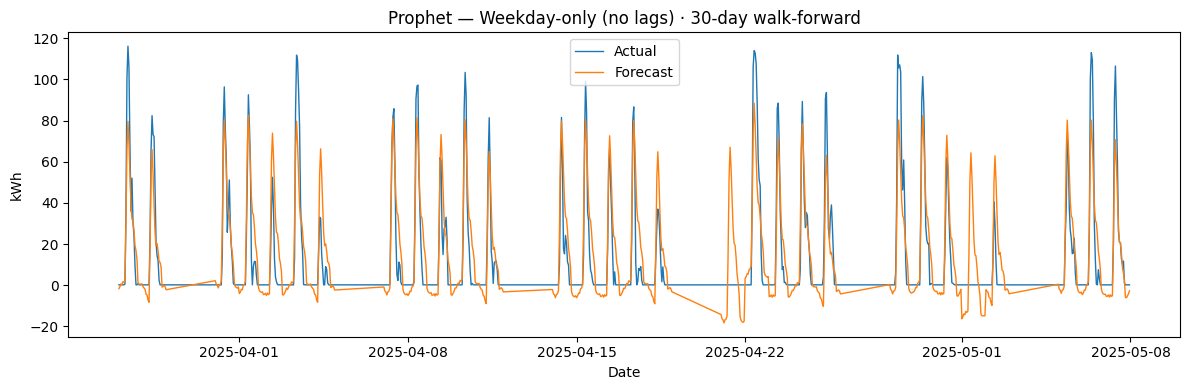

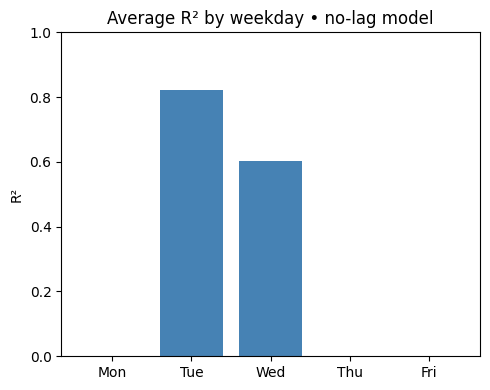

In [9]:
"""
Weekday-only Prophet back-test (no lag features)
===============================================

What’s inside
-------------
• **Data scope**      : All Monday→Friday hours. Saturdays & Sundays are dropped.  
• **Regressors**      : 
    – `fleet_size`   (step function you provided)  
    – `work_hours`  (1 between 07–18 h on weekdays, 0 otherwise)  
    – `holiday_flag` (1 on Belgian legal holidays, 0 elsewhere)  
• **Seasonalities**   : daily (24 h), weekly (7 d), monthly (~30 d)  
• **Calendar events**: Belgian public holidays + “terugkomdagen”  
• **Back-test**       : last 30 *weekday* days — walk-forward, 24 h horizon  
• **Outputs**         : MAE / RMSE / R² table, overall means, and an
                        Actual-vs-Forecast plot.

Just:

    pip install pandas numpy prophet matplotlib scikit-learn
    python prophet_weekday_only.py
"""

# ────────────────────────────────────────────────────────────────────────────
# 0.  Imports
# ────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30                      # last 30 weekdays

# put this once, near the top – right after the imports
pd.set_option('display.float_format', '{:.2f}'.format)

# ────────────────────────────────────────────────────────────────────────────
# 1.  Load and keep only weekdays
# ────────────────────────────────────────────────────────────────────────────
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .sort_values("Date")
        .rename(columns={"Date": "ds", "Chargers": "y"})
        .reset_index(drop=True))

# assert strict hourly cadence
expected = len(pd.date_range(df.ds.min(), df.ds.max(), freq="H"))
#assert len(df) == expected, "Series has missing hourly rows!"

df["weekday"] = df.ds.dt.weekday
df = df[df.weekday < 5].copy().reset_index(drop=True)   # drop Sat/Sun

# ────────────────────────────────────────────────────────────────────────────
# 2.  Holidays + terugkomdagen
# ────────────────────────────────────────────────────────────────────────────
be_holidays = [
    # 2024
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    # 2025
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]

holidays_df = pd.concat(
    [
        pd.DataFrame({"ds": pd.to_datetime(be_holidays),   "holiday": "be_holiday"}),
        pd.DataFrame({"ds": pd.to_datetime(terugkomdagen),"holiday": "back_to_work"}),
    ],
    ignore_index=True,
)
holiday_dates = set(pd.to_datetime(be_holidays).date)

df["holiday_flag"] = df.ds.dt.date.isin(holiday_dates).astype(int)

# ────────────────────────────────────────────────────────────────────────────
# 3.  Fleet-size step curve
# ────────────────────────────────────────────────────────────────────────────
fleet_steps = {
    "2024-06-20":35,"2024-06-25":36,"2024-09-05":38,"2024-09-12":41,
    "2024-09-27":42,"2024-10-15":43,"2024-10-29":45,"2024-11-05":46,
    "2024-11-26":47,"2025-01-09":48,"2025-01-23":49,"2025-01-28":50,
    "2025-02-04":51
}
steps = sorted([(pd.to_datetime(k), v) for k, v in fleet_steps.items()])
DEFAULT_FLEET = 35
def fleet_at(ts):
    vals = [v for d, v in steps if d <= ts]
    return max(vals) if vals else DEFAULT_FLEET
df["fleet_size"] = df.ds.apply(fleet_at)

# ────────────────────────────────────────────────────────────────────────────
# 4.  Work-hours dummy (07-18 h)
# ────────────────────────────────────────────────────────────────────────────
df["work_hours"] = df.ds.dt.hour.between(7, 18).astype(int)

# ────────────────────────────────────────────────────────────────────────────
# 5.  Select last 30 complete weekday days
# ────────────────────────────────────────────────────────────────────────────
unique_days = sorted(df.ds.dt.date.unique())           # weekdays only
test_days = []
ptr = unique_days[-2]                                  # “yesterday” in weekday timeline
while len(test_days) < BACKTEST_DAYS:
    if (df.ds.dt.date == ptr).sum() == 24:
        test_days.append(ptr)
    ptr = unique_days[unique_days.index(ptr)-1]        # step back one weekday
test_days = sorted(test_days)

# ────────────────────────────────────────────────────────────────────────────
# 6.  Build Prophet template (no lags)
# ────────────────────────────────────────────────────────────────────────────
def build_model():
    m = Prophet(
        holidays            = holidays_df,
        holidays_prior_scale= 100,          # << make holidays powerful
        daily_seasonality   = False,
        weekly_seasonality  = False,
        yearly_seasonality  = False
    )
    m.add_seasonality("daily", 1, 8)
    m.add_seasonality("weekly",7, 6)
    m.add_seasonality("monthly",30.5, 5)
    m.add_regressor("fleet_size")
    m.add_regressor("work_hours",  mode="multiplicative")
    m.add_regressor("holiday_flag",mode="additive", prior_scale=100)  # << power
    return m

# ────────────────────────────────────────────────────────────────────────────
# 7.  Walk-forward back-test (fit fresh each day)
# ────────────────────────────────────────────────────────────────────────────
metrics, preds = [], []

for day in test_days:
    tr = df[df.ds.dt.date < day][["ds","y","fleet_size","work_hours","holiday_flag"]]
    te = df[df.ds.dt.date == day][["ds","y","fleet_size","work_hours","holiday_flag"]]
    
    model = build_model()
    model.fit(tr)                         # train on all history up to D-1
    
    forecast = model.predict(te.drop(columns="y"))
    yhat = forecast["yhat"].values
    
    metrics.append({
        "Date": day,
        "MAE" : mean_absolute_error(te.y, yhat),
        "RMSE": mean_squared_error(te.y, yhat),
        "R2"  : r2_score(te.y, yhat)
    })
    
    tmp = te[["ds","y"]].rename(columns={"y":"Actual"})
    tmp["Forecast"] = yhat
    preds.append(tmp)

# ────────────────────────────────────────────────────────────────────────────
# 8.  Results & plots
# ────────────────────────────────────────────────────────────────────────────
res = pd.DataFrame(metrics).round(2)
print("\nWeekday-only metrics (last 30 days)\n", res)
print("\nAverages\n", res[["MAE","RMSE","R2"]].mean().round(2))

full = pd.concat(preds).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(full.ds, full.Actual,   lw=1, label="Actual")
plt.plot(full.ds, full.Forecast, lw=1, label="Forecast")
plt.title("Prophet — Weekday-only (no lags) · 30-day walk-forward")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

res["weekday"] = pd.to_datetime(res.Date).dt.weekday
wk = ["Mon","Tue","Wed","Thu","Fri"]
plt.figure(figsize=(5,4))
plt.bar(wk, res.groupby("weekday").R2.mean().reindex(range(5)), color="steelblue")
plt.title("Average R² by weekday • no-lag model"); plt.ylabel("R²"); plt.ylim(0,1)
plt.tight_layout(); plt.show()


11:07:50 - cmdstanpy - INFO - Chain [1] start processing
11:07:52 - cmdstanpy - INFO - Chain [1] done processing
11:08:24 - cmdstanpy - INFO - Chain [1] start processing
11:08:27 - cmdstanpy - INFO - Chain [1] done processing
11:09:18 - cmdstanpy - INFO - Chain [1] start processing
11:09:21 - cmdstanpy - INFO - Chain [1] done processing
11:10:16 - cmdstanpy - INFO - Chain [1] start processing
11:10:18 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:56 - cmdstanpy - INFO - Chain [1] done processing
11:11:29 - cmdstanpy - INFO - Chain [1] start processing
11:11:30 - cmdstanpy - INFO - Chain [1] done processing
11:12:00 - cmdstanpy - INFO - Chain [1] start processing
11:12:03 - cmdstanpy - INFO - Chain [1] done processing
11:12:40 - cmdstanpy - INFO - Chain [1] start processing
11:12:43 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:27 - cmdstanpy - INFO - Chain [1]


Weekday-only metrics (last 30 days)
           Date   MAE   RMSE            R2
0   2025-03-27 10.39 236.62          0.82
1   2025-03-28  7.58 126.54          0.83
2   2025-03-31  5.57  60.35          0.93
3   2025-04-01  8.35 146.46          0.79
4   2025-04-02  9.70 208.72         -0.04
5   2025-04-03 13.09 337.85          0.77
6   2025-04-04  9.68 209.29         -1.28
7   2025-04-07  7.40 128.26          0.83
8   2025-04-08  8.87 158.68          0.85
9   2025-04-09  5.68 115.63          0.67
10  2025-04-10 11.22 175.98          0.82
11  2025-04-11  5.67  61.96          0.87
12  2025-04-14  7.95 145.09          0.68
13  2025-04-15  8.77 134.59          0.83
14  2025-04-16  6.31  86.73          0.77
15  2025-04-17 12.42 263.24          0.57
16  2025-04-18  8.50 127.14          0.05
17  2025-04-21 19.50 646.39 -176372391.95
18  2025-04-22 15.19 569.61          0.69
19  2025-04-23  6.42  91.88          0.87
20  2025-04-24  5.96  54.51          0.91
21  2025-04-25  8.79 176.00          0

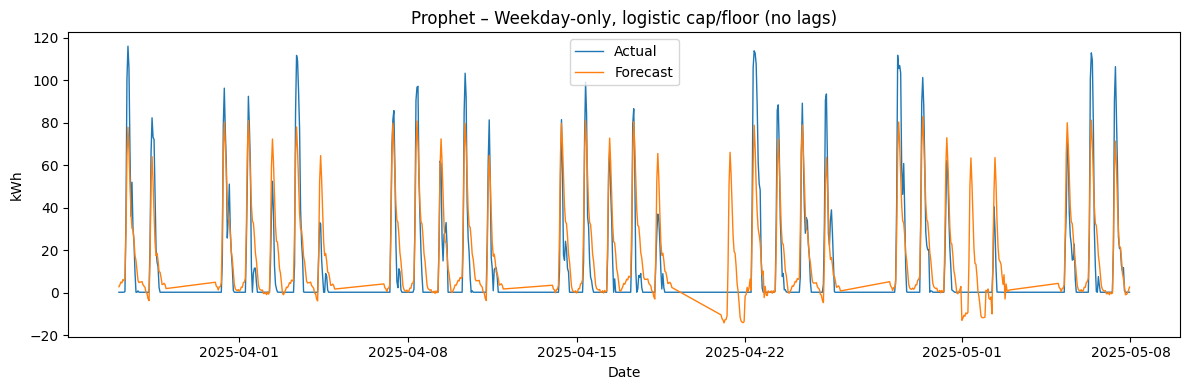

In [13]:
"""
Prophet — Weekday-only, NO lag features, with logistic cap/floor
================================================================

• Saturdays / Sundays are removed entirely.  
• Forward-known drivers only:
      – fleet_size      (step table)  
      – work_hours      (1 between 07-18 h on weekdays)  
      – holiday_flag    (1 on Belgian *legal* holidays)  
• Growth = 'logistic' with
      floor = 0  for every row  
      cap   = peak_kWh (≈120) on normal weekdays  
      cap   = 5 kWh    on legal-holiday rows → forces forecast ≈ 0  
• Walk-forward on the most-recent 30 **weekday** days (24 h horizon)
-------------------------------------------------------------------
Install once:  pip install pandas numpy prophet matplotlib scikit-learn
"""

# ─── Imports ──────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30                 # last 30 weekdays

pd.set_option('display.float_format', '{:.2f}'.format)


# ─── 1  Load & restrict to weekdays ───────────────────────────────
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .sort_values("Date")
        .rename(columns={"Date": "ds", "Chargers": "y"})
        .reset_index(drop=True))

df = df[df.ds.dt.weekday < 5].copy()          # drop Sat/Sun

# ─── 2  Belgian public holidays & “terugkomdagen” ────────────────
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]

holidays_df = pd.concat(
    [
        pd.DataFrame({"ds": pd.to_datetime(be_holidays), "holiday": "be_holiday"}),
        #pd.DataFrame({"ds": pd.to_datetime(terugkomdagen), "holiday": "back_to_work"}),
    ],
    ignore_index=True,
)

legal_holiday_dates = set(pd.to_datetime(be_holidays).date)
df["holiday_flag"] = df.ds.dt.date.isin(legal_holiday_dates).astype(int)

# ─── 3  Fleet-size step curve ────────────────────────────────────
fleet_steps = {
    "2024-06-20": 35, "2024-06-25": 36, "2024-09-05": 38, "2024-09-12": 41,
    "2024-09-27": 42, "2024-10-15": 43, "2024-10-29": 45, "2024-11-05": 46,
    "2024-11-26": 47, "2025-01-09": 48, "2025-01-23": 49, "2025-01-28": 50,
    "2025-02-04": 51
}
step_tbl = sorted((pd.to_datetime(k), v) for k, v in fleet_steps.items())
def fleet_at(ts):
    vals = [v for d, v in step_tbl if d <= ts]
    return max(vals) if vals else 35
df["fleet_size"] = df.ds.apply(fleet_at)

# ─── 4  Work-hours dummy ─────────────────────────────────────────
df["work_hours"] = df.ds.dt.hour.between(7, 18).astype(int)

# ─── 5  Logistic cap & floor columns ─────────────────────────────
peak_cap = df.y.quantile(0.99)      # ≈ 120 kWh observed
df["floor"] = 0
df["cap"]   = peak_cap
df.loc[df.holiday_flag == 1, "cap"] = 5    # squeeze legal holidays

# ─── 6  Pick last 30 complete weekday days ───────────────────────
days = sorted(df.ds.dt.date.unique())
test_days, ptr = [], days[-2]
while len(test_days) < BACKTEST_DAYS:
    if (df.ds.dt.date == ptr).sum() == 24:
        test_days.append(ptr)
    ptr = days[days.index(ptr) - 1]
test_days = sorted(test_days)

# ─── 7  Prophet builder (no lag features) ────────────────────────
def build_model():
    m = Prophet(
        growth="logistic",
        holidays=holidays_df,
        holidays_prior_scale=50,             # allow strong negative holiday effect
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
    )
    m.add_seasonality("daily",   1,   fourier_order=8)
    m.add_seasonality("weekly",  7,   fourier_order=6)
    m.add_seasonality("monthly", 30.5, fourier_order=5)
    m.add_regressor("fleet_size")
    m.add_regressor("work_hours",  mode="multiplicative")
    m.add_regressor("holiday_flag",mode="additive", prior_scale=50)
    return m

# ─── 8  Walk-forward back-test ───────────────────────────────────
pd.set_option('display.float_format', '{:.2f}'.format)

metrics, forecasts = [], []

for d in test_days:
    train = df[df.ds.dt.date < d]
    test  = df[df.ds.dt.date == d]
    
    model = build_model()
    model.fit(train[["ds","y","cap","floor","fleet_size","work_hours","holiday_flag"]])
    
    fut_cols = ["ds","cap","floor","fleet_size","work_hours","holiday_flag"]
    yhat = model.predict(test[fut_cols])["yhat"].values
    
    metrics.append({
        "Date": d,
        "MAE" : mean_absolute_error(test.y, yhat),
        "RMSE": mean_squared_error(test.y, yhat),
        "R2"  : r2_score(test.y, yhat)
    })
    
    out = test[["ds","y"]].rename(columns={"y":"Actual"})
    out["Forecast"] = yhat
    forecasts.append(out)

# ─── 9  Report & plots ───────────────────────────────────────────
res = pd.DataFrame(metrics)
print("\nWeekday-only metrics (last 30 days)\n", res)
print("\nAverages\n", res[["MAE","RMSE","R2"]].mean().round(2))

all_pred = pd.concat(forecasts).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(all_pred.ds, all_pred.Actual,   lw=1, label="Actual")
plt.plot(all_pred.ds, all_pred.Forecast, lw=1, label="Forecast")
plt.title("Prophet – Weekday-only, logistic cap/floor (no lags)")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()


11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:02 - cmdstanpy - INFO - Chain [1] done processing
11:45:33 - cmdstanpy - INFO - Chain [1] start processing
11:45:35 - cmdstanpy - INFO - Chain [1] done processing
11:46:18 - cmdstanpy - INFO - Chain [1] start processing
11:46:19 - cmdstanpy - INFO - Chain [1] done processing
11:47:10 - cmdstanpy - INFO - Chain [1] start processing
11:47:12 - cmdstanpy - INFO - Chain [1] done processing
11:48:09 - cmdstanpy - INFO - Chain [1] start processing
11:48:11 - cmdstanpy - INFO - Chain [1] done processing
11:49:02 - cmdstanpy - INFO - Chain [1] start processing
11:49:03 - cmdstanpy - INFO - Chain [1] done processing
11:49:55 - cmdstanpy - INFO - Chain [1] start processing
11:49:57 - cmdstanpy - INFO - Chain [1] done processing
11:50:48 - cmdstanpy - INFO - Chain [1] start processing
11:50:50 - cmdstanpy - INFO - Chain [1] done processing
11:51:41 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1]


Weekday-only metrics (30 days):
           Date   MAE   RMSE            R2
0   2025-03-27 10.37 241.06          0.82
1   2025-03-28  7.53 127.69          0.83
2   2025-03-31  5.31  59.55          0.93
3   2025-04-01  8.06 141.82          0.80
4   2025-04-02  9.52 202.00         -0.01
5   2025-04-03 13.08 337.21          0.77
6   2025-04-04  9.54 205.88         -1.25
7   2025-04-07  7.16 124.71          0.83
8   2025-04-08  8.58 155.94          0.85
9   2025-04-09  5.63 112.95          0.67
10  2025-04-10 10.86 170.28          0.82
11  2025-04-11  5.49  59.55          0.87
12  2025-04-14  7.52 136.64          0.70
13  2025-04-15  8.32 125.70          0.84
14  2025-04-16  5.94  81.05          0.79
15  2025-04-17 11.79 246.87          0.60
16  2025-04-18  7.80 111.57          0.17
17  2025-04-21 19.36 635.34 -173355750.41
18  2025-04-22 16.54 428.47          0.76
19  2025-04-23  6.48  90.96          0.88
20  2025-04-24  5.61  50.01          0.92
21  2025-04-25  8.88 181.75          0.76


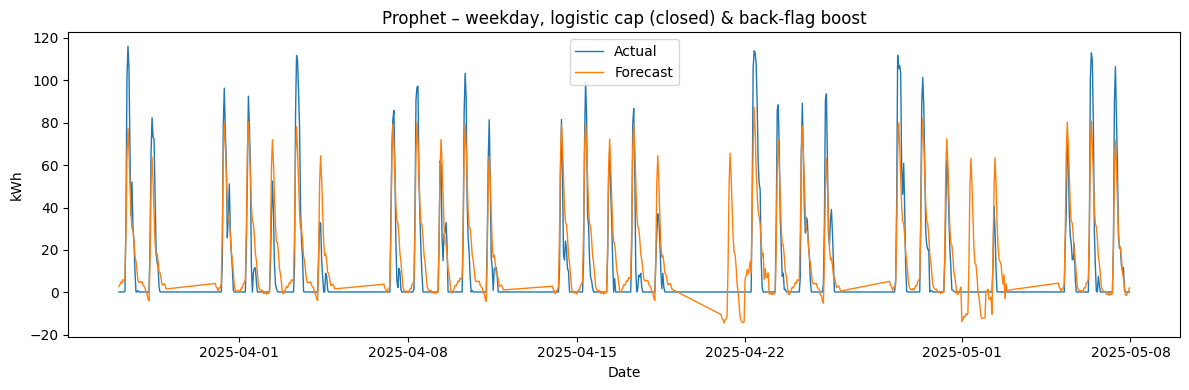

In [15]:
"""
Prophet  –  Weekday-only, no lags
=================================

Day classes
-----------
* **Normal weekday**          → typical load  
* **Closed weekday**          → Belgian legal holidays (offices shut)  
* **Terugkomdag (back day)**  → everyone is on-site, extra-busy  

Model design
------------
* **growth='logistic'**  
    floor = 0  always  
    cap   = peak_kWh (≈ 120) on normal + back days  
    cap   = 5 kWh on *closed* days  → forecast cannot spike  
* **Regressors**
    • fleet_size   (add)  
    • work_hours   (multiplicative)  
    • closed_flag  (add, prior_scale=50, pushes toward 0)  
    • back_flag    (add, prior_scale=50, lifts Terugkomdagen)  
* **Seasonalities** daily / weekly / monthly  
* **Training / test**  – last 30 *weekdays* (Mon-Fri) 24 h walk-forward

Run:

    pip install pandas numpy prophet matplotlib scikit-learn
"""

# ───────── Imports ───────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30                              # last 30 weekdays

# ───────── 1. Load & keep weekdays only ──────────────────────────
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .rename(columns={"Date":"ds","Chargers":"y"})
        .sort_values("ds")
        .reset_index(drop=True))

df = df[df.ds.dt.weekday < 5].copy().reset_index(drop=True)  # drop Sat/Sun

# assure strict hourly cadence on weekdays
hrs = df.groupby(df.ds.dt.date).size().unique()
#assert list(hrs) == [24], "Some weekdays missing hours"

# ───────── 2. Define calendars ──────────────────────────────────
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06"
]

legal_closed = set(pd.to_datetime(be_holidays).date)
back_days    = set(pd.to_datetime(terugkomdagen).date)

# Prophet holiday frame can keep both for extra flexibility
holidays_df = pd.concat(
    [pd.DataFrame({"ds":pd.to_datetime(be_holidays),   "holiday":"legal_holiday"}),
     pd.DataFrame({"ds":pd.to_datetime(terugkomdagen), "holiday":"terugkomdag"})],
    ignore_index=True
)

df["closed_flag"] = df.ds.dt.date.isin(legal_closed).astype(int)
df["back_flag"]   = df.ds.dt.date.isin(back_days).astype(int)

# ───────── 3. Fleet-size step curve ──────────────────────────────
fleet_steps = {
    "2024-06-20":35,"2024-06-25":36,"2024-09-05":38,"2024-09-12":41,
    "2024-09-27":42,"2024-10-15":43,"2024-10-29":45,"2024-11-05":46,
    "2024-11-26":47,"2025-01-09":48,"2025-01-23":49,"2025-01-28":50,
    "2025-02-04":51
}
steps = sorted((pd.to_datetime(k),v) for k,v in fleet_steps.items())
def fleet_at(ts):
    vals=[v for d,v in steps if d<=ts]
    return max(vals) if vals else 35
df["fleet_size"] = df.ds.apply(fleet_at)

# ───────── 4. Work-hours dummy ───────────────────────────────────
df["work_hours"] = df.ds.dt.hour.between(7,18).astype(int)

# ───────── 5. Logistic cap / floor ───────────────────────────────
peak_cap = df.y.quantile(0.99)           # ~120 kWh
df["floor"] = 0
df["cap"]   = peak_cap
df.loc[df.closed_flag==1, "cap"] = 5     # force near-zero on closed days

# ───────── 6. Select test days (last 30 weekdays) ───────────────
all_days = sorted(df.ds.dt.date.unique())
test_days, ptr = [], all_days[-2]
while len(test_days) < BACKTEST_DAYS:
    if (df.ds.dt.date == ptr).sum()==24:
        test_days.append(ptr)
    ptr = all_days[all_days.index(ptr)-1]
test_days = sorted(test_days)

# ───────── 7. Prophet builder ────────────────────────────────────
def build_model():
    m = Prophet(
        growth                 = "logistic",
        holidays               = holidays_df,
        holidays_prior_scale   = 50,
        daily_seasonality      = False,
        weekly_seasonality     = False,
        yearly_seasonality     = False,
    )
    m.add_seasonality("daily",   1,   fourier_order=8)
    m.add_seasonality("weekly",  7,   fourier_order=6)
    m.add_seasonality("monthly", 30.5,fourier_order=5)
    m.add_regressor("fleet_size")
    m.add_regressor("work_hours",  mode="multiplicative")
    m.add_regressor("closed_flag", mode="additive", prior_scale=50)
    m.add_regressor("back_flag",   mode="additive", prior_scale=50)
    return m

# ───────── 8. Walk-forward back-test ─────────────────────────────
pd.set_option('display.float_format', '{:.2f}'.format)

metrics, pred_frames = [], []

for d in test_days:
    train = df[df.ds.dt.date < d]
    test  = df[df.ds.dt.date == d]
    
    mdl = build_model()
    mdl.fit(train[["ds","y","cap","floor","fleet_size","work_hours",
                   "closed_flag","back_flag"]])
    
    fut_cols = ["ds","cap","floor","fleet_size","work_hours",
                "closed_flag","back_flag"]
    yhat = mdl.predict(test[fut_cols])["yhat"].values
    
    metrics.append({
        "Date": d,
        "MAE" : mean_absolute_error(test.y, yhat),
        "RMSE": mean_squared_error(test.y, yhat),
        "R2"  : r2_score(test.y, yhat)
    })
    
    tmp = test[["ds","y"]].rename(columns={"y":"Actual"})
    tmp["Forecast"] = yhat
    pred_frames.append(tmp)

# ───────── 9. Results & plots ────────────────────────────────────
res = pd.DataFrame(metrics)
print("\nWeekday-only metrics (30 days):\n", res)
print("\nAverages:\n", res[["MAE","RMSE","R2"]].mean().round(2))

full = pd.concat(pred_frames).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(full.ds, full.Actual,   lw=1, label="Actual")
plt.plot(full.ds, full.Forecast, lw=1, label="Forecast")
plt.title("Prophet – weekday, logistic cap (closed) & back-flag boost")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()


13:01:25 - cmdstanpy - INFO - Chain [1] start processing
13:01:29 - cmdstanpy - INFO - Chain [1] done processing
13:01:30 - cmdstanpy - INFO - Chain [1] start processing
13:01:34 - cmdstanpy - INFO - Chain [1] done processing
13:01:35 - cmdstanpy - INFO - Chain [1] start processing
13:01:39 - cmdstanpy - INFO - Chain [1] done processing
13:01:40 - cmdstanpy - INFO - Chain [1] start processing
13:01:45 - cmdstanpy - INFO - Chain [1] done processing
13:01:46 - cmdstanpy - INFO - Chain [1] start processing
13:01:50 - cmdstanpy - INFO - Chain [1] done processing
13:01:51 - cmdstanpy - INFO - Chain [1] start processing
13:01:56 - cmdstanpy - INFO - Chain [1] done processing
13:01:57 - cmdstanpy - INFO - Chain [1] start processing
13:01:58 - cmdstanpy - INFO - Chain [1] done processing
13:01:59 - cmdstanpy - INFO - Chain [1] start processing
13:02:00 - cmdstanpy - INFO - Chain [1] done processing
13:02:01 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1]


Weekday-only metrics (last 30 days)
           Date   MAE   RMSE            R2
0   2025-03-27  9.85 229.07          0.83
1   2025-03-28  7.31 122.11          0.84
2   2025-03-31  4.85  56.93          0.93
3   2025-04-01  7.99 151.56          0.79
4   2025-04-02  9.76 196.52          0.02
5   2025-04-03 12.56 343.07          0.77
6   2025-04-04 10.78 248.94         -1.72
7   2025-04-07  7.99 147.38          0.80
8   2025-04-08  9.15 163.88          0.84
9   2025-04-09  7.45 133.64          0.61
10  2025-04-10  9.55 171.42          0.82
11  2025-04-11  6.02  69.68          0.85
12  2025-04-14  9.51 162.61          0.64
13  2025-04-15  9.27 138.77          0.83
14  2025-04-16  8.15 100.02          0.74
15  2025-04-17 10.20 250.59          0.59
16  2025-04-18  8.62 129.86          0.03
17  2025-04-21 21.87 725.27 -197893843.25
18  2025-04-22 15.22 512.70          0.72
19  2025-04-23  8.24 100.74          0.86
20  2025-04-24  4.01  44.22          0.93
21  2025-04-25  9.80 186.72          0

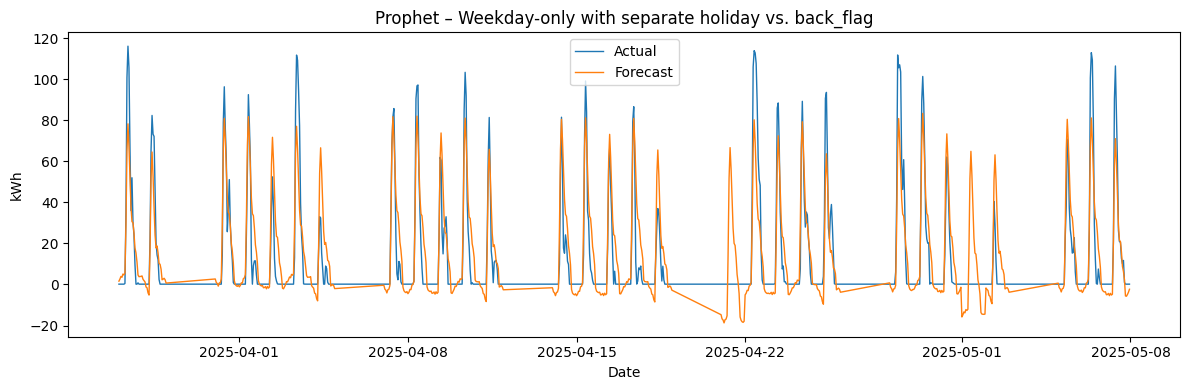

In [18]:
"""
Prophet – Weekday-only with separate holiday vs. terugkomdag handling
=====================================================================

• Drop all Saturdays & Sundays.  
• Belgian legal holidays in Prophet’s `holidays_df` → strong negative additive effect.  
• Terugkomdagen as a separate regressor `back_flag` → strong positive additive effect.  
• Logistic growth with per-row cap/floor:
    – floor = 0 always  
    – cap   = high (99th percentile) on normal & terugkomdag days  
    – cap   = low (5 kWh) on legal holidays  
• Forward-known regressors only:
    – fleet_size (step function)  
    – work_hours (1 between 07–18 h)  
    – back_flag  (1 on terugkomdag)  
• Walk-forward back-test on the last 30 weekdays (24h horizon).  
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30

pd.set_option('display.float_format', '{:.2f}'.format)

# 1. Load & keep only weekdays -----------------------------------
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .rename(columns={"Date":"ds","Chargers":"y"})
        .sort_values("ds")
        .reset_index(drop=True))
df = df[df.ds.dt.weekday < 5].reset_index(drop=True)  # drop Sat & Sun

# 2. Define Belgian legal holidays & terugkomdagen --------------
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]

# Build holidays_df with ONLY legal holidays
holidays_df = pd.DataFrame({
    "ds": pd.to_datetime(be_holidays),
    "holiday": "legal_holiday"
})

legal_set = set(pd.to_datetime(be_holidays).date)
back_set  = set(pd.to_datetime(terugkomdagen).date)

# 3. Create flags -----------------------------------------------
df["holiday_flag"] = df.ds.dt.date.isin(legal_set).astype(int)
df["back_flag"]    = df.ds.dt.date.isin(back_set).astype(int)

# 4. Fleet-size step curve --------------------------------------
fleet_steps = {
    "2024-06-20":35,"2024-06-25":36,"2024-09-05":38,"2024-09-12":41,
    "2024-09-27":42,"2024-10-15":43,"2024-10-29":45,"2024-11-05":46,
    "2024-11-26":47,"2025-01-09":48,"2025-01-23":49,"2025-01-28":50,
    "2025-02-04":51
}
steps = sorted((pd.to_datetime(k), v) for k, v in fleet_steps.items())
def fleet_at(ts):
    vals = [v for d, v in steps if d <= ts]
    return max(vals) if vals else 35
df["fleet_size"] = df.ds.apply(fleet_at)

# 5. Work-hours dummy -------------------------------------------
df["work_hours"] = df.ds.dt.hour.between(7,18).astype(int)

# 6. Logistic cap & floor ---------------------------------------
peak_cap = df.y.quantile(0.99)  # ~120 kWh
df["floor"] = 0
df["cap"]   = peak_cap
df.loc[df.holiday_flag==1, "cap"] = 5  # enforce near-zero on legal holidays

# 7. Select last 30 complete weekday dates ----------------------
unique_days = sorted(df.ds.dt.date.unique())
test_days = []
ptr = unique_days[-2]
while len(test_days) < BACKTEST_DAYS:
    if (df.ds.dt.date == ptr).sum() == 24:
        test_days.append(ptr)
    ptr = unique_days[unique_days.index(ptr)-1]
test_days = sorted(test_days)

# 8. Prophet builder with separate holiday vs back-flag priors ----
def build_model():
    m = Prophet(
        
        holidays              = holidays_df,
        holidays_prior_scale  = 50,      # strong negative holiday effect
        daily_seasonality     = False,
        weekly_seasonality    = False,
        yearly_seasonality    = False,
    )
    m.add_seasonality("daily",   1,   fourier_order=8)
    m.add_seasonality("weekly",  7,   fourier_order=6)
    m.add_seasonality("monthly", 30.5,fourier_order=5)
    m.add_regressor("fleet_size")
    m.add_regressor("work_hours",    mode="multiplicative")
    m.add_regressor("holiday_flag",  mode="additive", prior_scale=50)
    #m.add_regressor("back_flag",     mode="additive", prior_scale=50)
    return m

# 9. Walk-forward back-test --------------------------------------
pd.set_option('display.float_format', '{:.2f}'.format)

metrics, predictions = [], []

for day in test_days:
    train = df[df.ds.dt.date < day]
    test  = df[df.ds.dt.date == day]
    
    m = build_model()
    m.fit(train[["ds","y","cap","floor",
                 "fleet_size","work_hours","holiday_flag","back_flag"]])
    
    future = test[["ds","cap","floor",
                   "fleet_size","work_hours","holiday_flag","back_flag"]]
    yhat   = m.predict(future)["yhat"].values
    
    metrics.append({
        "Date": day,
        "MAE" : mean_absolute_error(test.y, yhat),
        "RMSE": mean_squared_error(test.y, yhat),
        "R2"  : r2_score(test.y, yhat)
    })
    
    tmp = test[["ds","y"]].rename(columns={"y":"Actual"})
    tmp["Forecast"] = yhat
    predictions.append(tmp)

# 10. Results & plots -------------------------------------------
res = pd.DataFrame(metrics)
print("\nWeekday-only metrics (last 30 days)\n", res)
print("\nAverages\n", res[["MAE","RMSE","R2"]].mean().round(2))

full = pd.concat(predictions).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(full.ds, full.Actual,   lw=1, label="Actual")
plt.plot(full.ds, full.Forecast, lw=1, label="Forecast")
plt.title("Prophet – Weekday-only with separate holiday vs. back_flag")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()


13:37:53 - cmdstanpy - INFO - Chain [1] start processing
13:37:57 - cmdstanpy - INFO - Chain [1] done processing
13:37:57 - cmdstanpy - INFO - Chain [1] start processing
13:38:01 - cmdstanpy - INFO - Chain [1] done processing
13:38:02 - cmdstanpy - INFO - Chain [1] start processing
13:38:06 - cmdstanpy - INFO - Chain [1] done processing
13:38:07 - cmdstanpy - INFO - Chain [1] start processing
13:38:12 - cmdstanpy - INFO - Chain [1] done processing
13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:17 - cmdstanpy - INFO - Chain [1] done processing
13:38:17 - cmdstanpy - INFO - Chain [1] start processing
13:38:22 - cmdstanpy - INFO - Chain [1] done processing
13:38:23 - cmdstanpy - INFO - Chain [1] start processing
13:38:23 - cmdstanpy - INFO - Chain [1] done processing
13:38:24 - cmdstanpy - INFO - Chain [1] start processing
13:38:25 - cmdstanpy - INFO - Chain [1] done processing
13:38:25 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1]


Metrics (last 30 weekdays)
           Date   MAE   RMSE            R2
0   2025-03-27  9.85 229.07          0.83
1   2025-03-28  7.31 122.11          0.84
2   2025-03-31  4.85  56.93          0.93
3   2025-04-01  7.99 151.56          0.79
4   2025-04-02  9.76 196.52          0.02
5   2025-04-03 12.56 343.07          0.77
6   2025-04-04 10.78 248.94         -1.72
7   2025-04-07  7.99 147.38          0.80
8   2025-04-08  9.15 163.88          0.84
9   2025-04-09  7.45 133.64          0.61
10  2025-04-10  9.55 171.42          0.82
11  2025-04-11  6.02  69.68          0.85
12  2025-04-14  9.51 162.61          0.64
13  2025-04-15  9.27 138.77          0.83
14  2025-04-16  8.15 100.02          0.74
15  2025-04-17 10.20 250.59          0.59
16  2025-04-18  8.62 129.86          0.03
17  2025-04-21 21.87 725.27 -197893843.25
18  2025-04-22 15.22 512.70          0.72
19  2025-04-23  8.24 100.74          0.86
20  2025-04-24  4.01  44.22          0.93
21  2025-04-25  9.80 186.72          0.76
22  2

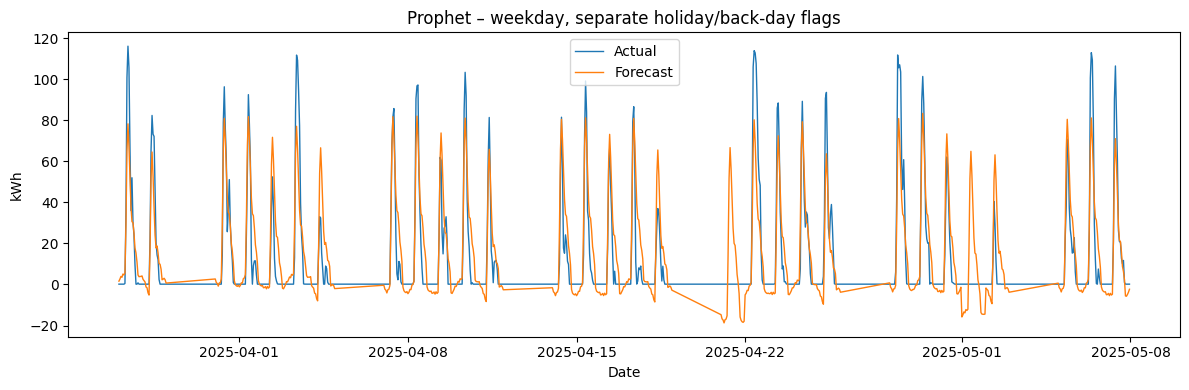

13:38:58 - cmdstanpy - INFO - Chain [1] start processing
13:38:59 - cmdstanpy - INFO - Chain [1] done processing
13:38:59 - cmdstanpy - INFO - Chain [1] start processing
13:39:00 - cmdstanpy - INFO - Chain [1] done processing



Feature permutation importance (ΔR²):
     feature        ΔR2
  fleet_size       0.00
holiday_flag       0.00
   back_flag       0.00
  work_hours -963713.79


In [24]:
"""
Prophet – Weekday-only with separate holiday vs. terugkomdag flags
and feature-importance summary
=====================================================================

• Drop all Saturdays & Sundays.  
• Belgian legal holidays in Prophet’s `holidays_df` → strong negative additive effect.  
• Terugkomdagen as a separate regressor `back_flag` → strong positive additive effect.  
• Logistic growth with per-row cap/floor:
    – floor = 0 always  
    – cap   = high (99th percentile) on normal & terugkomdag days  
    – cap   = low (5 kWh) on legal holidays  
• Forward-known regressors only:
    – fleet_size (step function)  
    – work_hours (1 between 07–18 h)  
    – holiday_flag (legal holidays)  
    – back_flag    (terugkomdagen)  
• Walk-forward back-test on the last 30 weekdays (24h horizon).  
• Finally: feature importance from regressor coefficients.  
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "Charging_data_cleaned.csv"
BACKTEST_DAYS = 30

# 1. Load & keep only weekdays -----------------------------------
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .rename(columns={"Date":"ds","Chargers":"y"})
        .sort_values("ds")
        .reset_index(drop=True))
# drop Saturdays (5) and Sundays (6)
df = df[df.ds.dt.weekday < 5].reset_index(drop=True)

# 2. Calendar definitions -----------------------------------------
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
# Prophet holidays_df only for legal holidays
holidays_df = pd.DataFrame({
    "ds": pd.to_datetime(be_holidays),
    "holiday": "legal_holiday"
})
legal_set = set(pd.to_datetime(be_holidays).date)
back_set  = set(pd.to_datetime(terugkomdagen).date)

# 3. Flags --------------------------------------------------------
df["holiday_flag"] = df.ds.dt.date.isin(legal_set).astype(int)  # 1 on legal holidays
df["back_flag"]    = df.ds.dt.date.isin(back_set).astype(int)   # 1 on terugkomdag

# 4. Fleet-size step curve ---------------------------------------
fleet_steps = {
    "2024-06-20":35,"2024-06-25":36,"2024-09-05":38,"2024-09-12":41,
    "2024-09-27":42,"2024-10-15":43,"2024-10-29":45,"2024-11-05":46,
    "2024-11-26":47,"2025-01-09":48,"2025-01-23":49,"2025-01-28":50,
    "2025-02-04":51
}
steps = sorted((pd.to_datetime(k),v) for k,v in fleet_steps.items())
def fleet_at(ts):
    vals = [v for d,v in steps if d <= ts]
    return max(vals) if vals else 35
df["fleet_size"] = df.ds.apply(fleet_at)

# 5. Work-hours dummy --------------------------------------------
df["work_hours"] = df.ds.dt.hour.between(7,18).astype(int)

# 6. Logistic cap & floor ----------------------------------------
peak_cap = df.y.quantile(0.99)  # ~120 kWh
df["floor"] = 0
df["cap"]   = peak_cap
df.loc[df.holiday_flag==1, "cap"] = 5  # force near-zero on legal holidays

# 7. Select last 30 complete weekday dates -----------------------
unique_days = sorted(df.ds.dt.date.unique())
test_days, ptr = [], unique_days[-2]
while len(test_days) < BACKTEST_DAYS:
    if (df.ds.dt.date == ptr).sum() == 24:
        test_days.append(ptr)
    ptr = unique_days[unique_days.index(ptr)-1]
test_days = sorted(test_days)

# 8. Prophet builder with separate priors ------------------------
def build_model():
    m = Prophet(
        
        holidays              = holidays_df,
        holidays_prior_scale  = 50,      # allow strong negative holiday effect
        daily_seasonality     = False,
        weekly_seasonality    = False,
        yearly_seasonality    = False,
    )
    m.add_seasonality("daily",   period=1,   fourier_order=8)
    m.add_seasonality("weekly",  period=7,   fourier_order=6)
    m.add_seasonality("monthly", period=30.5,fourier_order=5)
    # forward-known regressors:
    m.add_regressor("fleet_size")                       # additive
    m.add_regressor("work_hours",    mode="multiplicative")
    m.add_regressor("holiday_flag",  mode="additive", prior_scale=50)
    #m.add_regressor("back_flag",     mode="additive", prior_scale=50)
    return m

pd.set_option('display.float_format','{:.2f}'.format)

# 9. Walk-forward back-test ---------------------------------------
metrics, preds = [], []
for day in test_days:
    train = df[df.ds.dt.date < day]
    test  = df[df.ds.dt.date == day]
    
    m = build_model()
    m.fit(train[["ds","y","cap","floor",
                 "fleet_size","work_hours",
                 "holiday_flag","back_flag"]])
    
    fut = test[["ds","cap","floor",
                "fleet_size","work_hours",
                "holiday_flag","back_flag"]]
    yhat = m.predict(fut)["yhat"].values
    
    metrics.append({
        "Date": day,
        "MAE" : mean_absolute_error(test.y, yhat),
        "RMSE": mean_squared_error(test.y, yhat),
        "R2"  : r2_score(test.y, yhat)
    })
    tmp = test[["ds","y"]].rename(columns={"y":"Actual"})
    tmp["Forecast"] = yhat
    preds.append(tmp)

# 10. Backtest results --------------------------------------------
res = pd.DataFrame(metrics)
print("\nMetrics (last 30 weekdays)\n", res)
print("\nAverages\n", res[["MAE","RMSE","R2"]].mean())

# 11. Plot Actual vs Forecast -------------------------------------
full = pd.concat(preds).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(full.ds, full.Actual,   label="Actual",   lw=1)
plt.plot(full.ds, full.Forecast, label="Forecast", lw=1)
plt.title("Prophet – weekday, separate holiday/back-day flags")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()

# ───────── 12. Feature importance summary ─────────────────────────
# Fit a final model on all available (weekday) history
final_m = build_model()
final_m.fit(df[["ds","y","cap","floor",
                "fleet_size","work_hours",
                "holiday_flag","back_flag"]])

# ───────── 10b. Permutation importance by ΔR² ─────────────────────────────
# Train one global model on all weekday data
global_m = build_model()
global_m.fit(df[["ds","y","cap","floor",
                 "fleet_size","work_hours",
                 "holiday_flag","back_flag"]])

# Baseline R² per day, then averaged
baseline_r2 = []
for d in test_days:
    test = df[df.ds.dt.date == d]
    fut  = test[["ds","cap","floor",
                 "fleet_size","work_hours",
                 "holiday_flag","back_flag"]]
    yhat = global_m.predict(fut)["yhat"].values
    baseline_r2.append(r2_score(test.y, yhat))
base_r2 = np.mean(baseline_r2)

# Permute each feature and measure drop in R²
features = ["fleet_size","work_hours","holiday_flag","back_flag"]
importances = []
for feat in features:
    perm_r2 = []
    for d in test_days:
        test = df[df.ds.dt.date == d]
        fut  = test[["ds","cap","floor",
                     "fleet_size","work_hours",
                     "holiday_flag","back_flag"]].copy()
        fut[feat] = np.random.permutation(fut[feat].values)
        yhat_p   = global_m.predict(fut)["yhat"].values
        perm_r2.append(r2_score(test.y, yhat_p))
    importances.append((feat, base_r2 - np.mean(perm_r2)))

imp_df = (
    pd.DataFrame(importances, columns=["feature","ΔR2"])
      .sort_values("ΔR2", ascending=False)
)

print("\nFeature permutation importance (ΔR²):")
print(imp_df.to_string(index=False))


15:29:42 - cmdstanpy - INFO - Chain [1] start processing
15:29:44 - cmdstanpy - INFO - Chain [1] done processing
15:29:45 - cmdstanpy - INFO - Chain [1] start processing
15:29:46 - cmdstanpy - INFO - Chain [1] done processing
15:29:48 - cmdstanpy - INFO - Chain [1] start processing
15:29:49 - cmdstanpy - INFO - Chain [1] done processing
15:29:51 - cmdstanpy - INFO - Chain [1] start processing
15:29:52 - cmdstanpy - INFO - Chain [1] done processing
15:29:54 - cmdstanpy - INFO - Chain [1] start processing
15:29:55 - cmdstanpy - INFO - Chain [1] done processing
15:29:56 - cmdstanpy - INFO - Chain [1] start processing
15:29:58 - cmdstanpy - INFO - Chain [1] done processing
15:29:59 - cmdstanpy - INFO - Chain [1] start processing
15:30:00 - cmdstanpy - INFO - Chain [1] done processing
15:30:01 - cmdstanpy - INFO - Chain [1] start processing
15:30:03 - cmdstanpy - INFO - Chain [1] done processing
15:30:04 - cmdstanpy - INFO - Chain [1] start processing
15:30:06 - cmdstanpy - INFO - Chain [1]


Metrics (last 30 weekdays)
           Date   MAE   RMSE            R2
0   2025-04-08  8.09 112.88          0.89
1   2025-04-09  5.98  78.08          0.77
2   2025-04-10  7.89 118.77          0.88
3   2025-04-11  5.31  63.82          0.86
4   2025-04-12  3.84  16.66   -2440969.65
5   2025-04-13  3.53  13.31   -5240829.44
6   2025-04-14  7.36 124.34          0.72
7   2025-04-15  7.53  91.09          0.89
8   2025-04-16  5.14  50.80          0.87
9   2025-04-17  8.63 202.95          0.67
10  2025-04-18  5.90  68.82          0.49
11  2025-04-19  3.69  15.14   -1856005.22
12  2025-04-20  3.37  12.69   -2032852.44
13  2025-04-21 19.89 664.24 -181241111.81
14  2025-04-22 15.33 522.26          0.71
15  2025-04-23  7.34 115.35          0.84
16  2025-04-24  3.79  21.06          0.97
17  2025-04-25  9.85 224.33          0.71
18  2025-04-26  3.47  13.50   -1433612.28
19  2025-04-27  3.19  12.62   -1553535.69
20  2025-04-28 13.04 401.43          0.75
21  2025-04-29  5.49  63.78          0.94
22  2

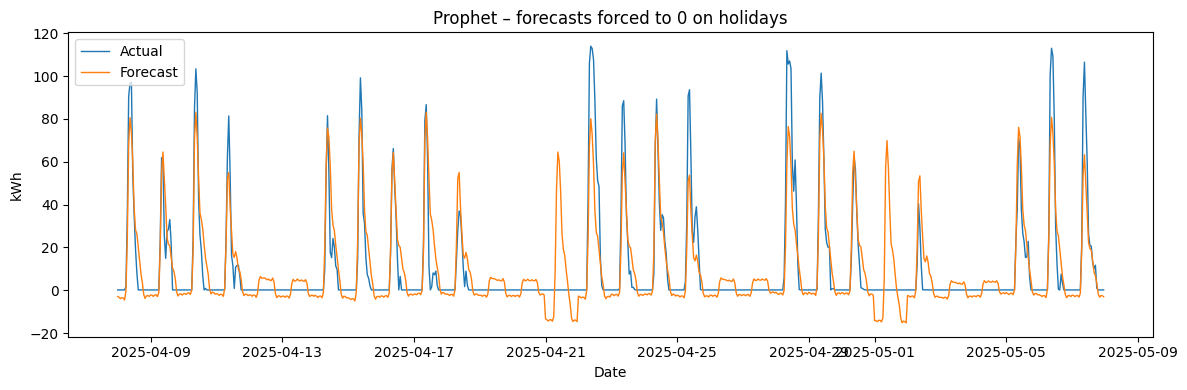

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH      = "./Charging_data_cleaned.csv"
BACKTEST_DAYS = 30

# 1) Load & keep weekdays ------------------------------------------
df = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .rename(columns={"Date":"ds","Chargers":"y"})
        .sort_values("ds")
        .reset_index(drop=True))
  # drop Sat & Sun

# 1.5) Add weekday and hour features + compute avg by weekday & hour
df["weekday"] = df.ds.dt.weekday
df["hour"] = df.ds.dt.hour

# Compute average y by weekday and hour
avg_map = df.groupby(['weekday', 'hour'])['y'].mean().reset_index()
avg_map = avg_map.rename(columns={'y': 'avg_hourly_by_weekday'})

# Merge averages back to the main dataframe
df = pd.merge(df, avg_map, on=['weekday', 'hour'], how='left')

# 2) Calendar definitions ------------------------------------------
be_holidays = [
    "2024-01-01","2024-04-01","2024-05-01","2024-05-09","2024-05-20",
    "2024-07-21","2024-08-15","2024-11-01","2024-11-11","2024-12-25",
    "2025-01-01","2025-04-21","2025-05-01","2025-05-29","2025-06-09",
    "2025-07-21","2025-08-15","2025-11-01","2025-11-11","2025-12-25",
]
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
legal_set = set(pd.to_datetime(be_holidays).date)
back_set  = set(pd.to_datetime(terugkomdagen).date)

# 3) Flags ----------------------------------------------------------
df["holiday_flag"] = df.ds.dt.date.isin(legal_set).astype(int)  # flag legal holidays
df["back_flag"]    = df.ds.dt.date.isin(back_set).astype(int)   # flag terugkomdag

# 4) Fleet-size step curve -----------------------------------------
fleet_steps = {
    "2024-06-20":35,"2024-06-25":36,"2024-09-05":38,"2024-09-12":41,
    "2024-09-27":42,"2024-10-15":43,"2024-10-29":45,"2024-11-05":46,
    "2024-11-26":47,"2025-01-09":48,"2025-01-23":49,"2025-01-28":50,
    "2025-02-04":51
}
steps = sorted((pd.to_datetime(k),v) for k,v in fleet_steps.items())
def fleet_at(ts):
    vals = [v for d,v in steps if d <= ts]
    return max(vals) if vals else 35
df["fleet_size"] = df.ds.apply(fleet_at)

# 5) Work-hours dummy ----------------------------------------------
df["work_hours"] = df.ds.dt.hour.between(7,18).astype(int)

# 6) Logistic cap & floor ------------------------------------------
peak_cap = df.y.quantile(0.99)
df["floor"] = 0
df["cap"]   = peak_cap
df.loc[df.holiday_flag==1, "cap"] = 5   # still cap holidays low if needed

# 7) Select last 30 weekdays --------------------------------------
unique_days = sorted(df.ds.dt.date.unique())
test_days, ptr = [], unique_days[-2]
while len(test_days)<BACKTEST_DAYS:
    if (df.ds.dt.date==ptr).sum()==24:
        test_days.append(ptr)
    ptr = unique_days[unique_days.index(ptr)-1]
test_days = sorted(test_days)

# 8) Prophet builder -----------------------------------------------
def build_model():
    m = Prophet(
        daily_seasonality    =False,
        weekly_seasonality   =False,
        yearly_seasonality   =False,
    )
    m.add_seasonality("daily",   period=1,   fourier_order=8)
    m.add_seasonality("weekly",  period=7,   fourier_order=6)
    m.add_seasonality("monthly", period=30.5,fourier_order=5)
    m.add_regressor("fleet_size")                     # additive
    m.add_regressor("work_hours", mode="multiplicative")
    m.add_regressor("holiday_flag", mode="additive", prior_scale=50)
    m.add_regressor("avg_hourly_by_weekday", mode="additive")
    return m

pd.set_option('display.float_format','{:.2f}'.format)

# 9) Walk-forward back-test ----------------------------------------
metrics, preds = [], []
for day in test_days:
    train = df[df.ds.dt.date < day]
    test  = df[df.ds.dt.date == day]

    m = build_model()
    m.fit(train[["ds","y","cap","floor",
                 "fleet_size","work_hours",
                 "holiday_flag","back_flag",
                 "avg_hourly_by_weekday"]])

    fut = test[["ds","cap","floor",
                "fleet_size","work_hours",
                "holiday_flag","back_flag",
                "avg_hourly_by_weekday"]]
    yhat = m.predict(fut)["yhat"].values

    metrics.append({
        "Date": day,
        "MAE" : mean_absolute_error(test.y, yhat),
        "RMSE": mean_squared_error(test.y, yhat),
        "R2"  : r2_score(test.y, yhat),
    })
    tmp = test[["ds","y"]].rename(columns={"y":"Actual"})
    tmp["Forecast"] = yhat
    preds.append(tmp)

res = pd.DataFrame(metrics)
print("\nMetrics (last 30 weekdays)\n", res)
print("\nAverages\n", res[["MAE","RMSE","R2"]].mean())

# 10) Plot Actual vs Forecast --------------------------------------
full = pd.concat(preds).sort_values("ds")
plt.figure(figsize=(12,4))
plt.plot(full.ds, full.Actual,   label="Actual",   lw=1)
plt.plot(full.ds, full.Forecast, label="Forecast", lw=1)
plt.title("Prophet – forecasts forced to 0 on holidays")
plt.ylabel("kWh"); plt.xlabel("Date"); plt.legend(); plt.tight_layout(); plt.show()


16:01:25 - cmdstanpy - INFO - Chain [1] start processing
16:01:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



--- Forecast for Last 24 Hours ---
                      ds  yhat
8735 2025-05-07 01:00:00  0.76
8736 2025-05-07 02:00:00  0.59
8737 2025-05-07 03:00:00  0.62
8738 2025-05-07 04:00:00  0.73
8739 2025-05-07 05:00:00  0.80
8740 2025-05-07 06:00:00  1.02
8741 2025-05-07 07:00:00 16.66
8742 2025-05-07 08:00:00 50.44
8743 2025-05-07 09:00:00 60.93
8744 2025-05-07 10:00:00 47.66
8745 2025-05-07 11:00:00 34.45
8746 2025-05-07 12:00:00 20.11
8747 2025-05-07 13:00:00 17.21
8748 2025-05-07 14:00:00 16.06
8749 2025-05-07 15:00:00 11.68
8750 2025-05-07 16:00:00  6.35
8751 2025-05-07 17:00:00  3.88
8752 2025-05-07 18:00:00  2.17
8753 2025-05-07 19:00:00  1.54
8754 2025-05-07 20:00:00  1.45
8755 2025-05-07 21:00:00  1.38
8756 2025-05-07 22:00:00  1.35
8757 2025-05-07 23:00:00  1.37


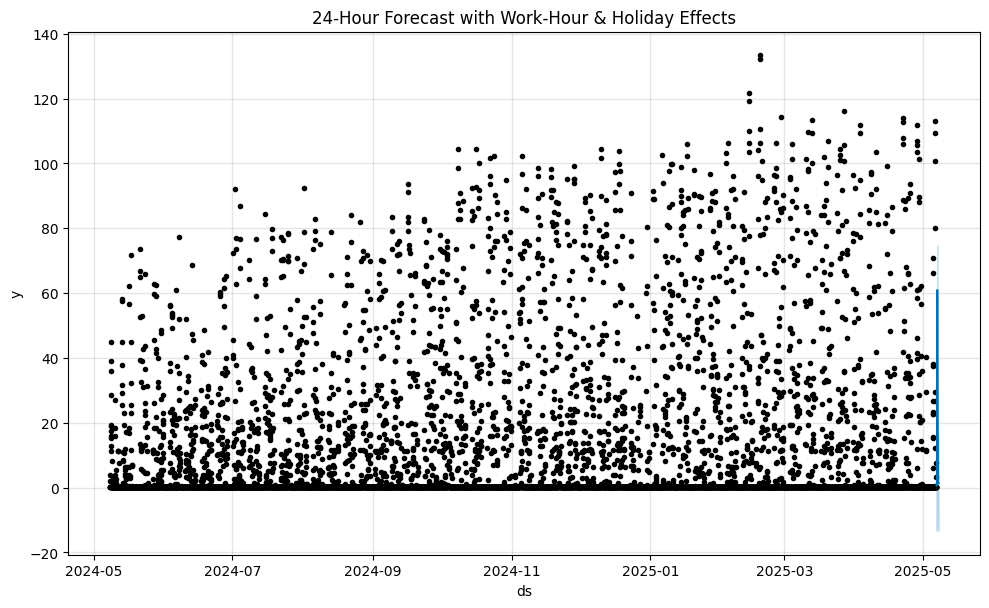

16:01:28 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



--- Backtest Metrics (Last 30 Days) ---
MAE:  6.47
RMSE: 12.43
R2:   0.73


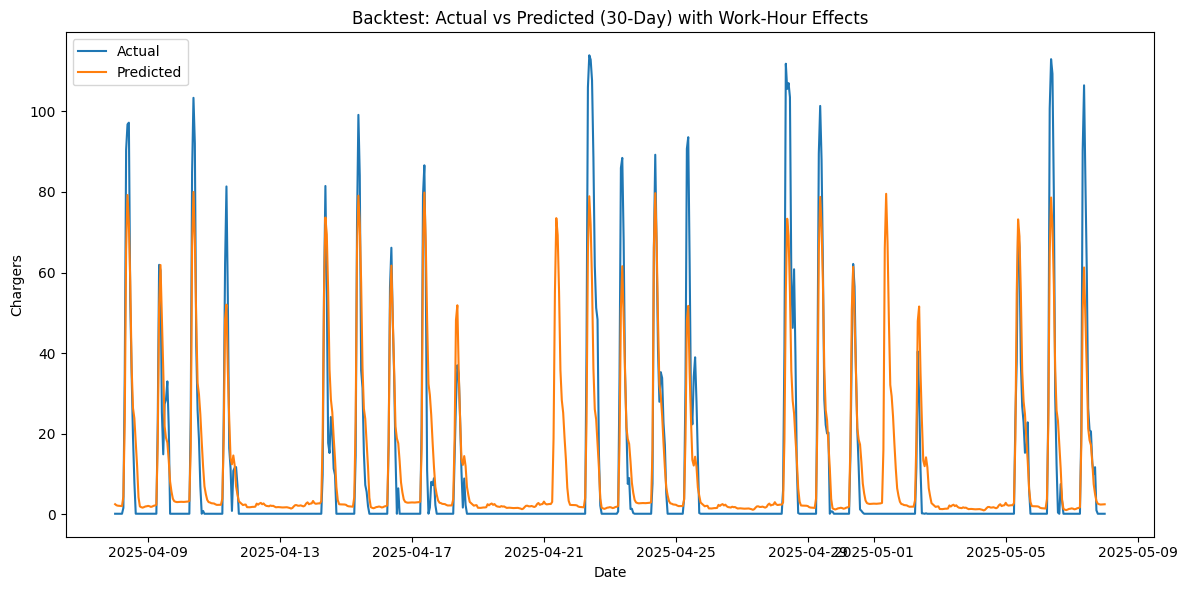

In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import holidays

# --- Load and preprocess data ---
df = pd.read_csv("./Charging_data_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.rename(columns={"Date": "ds", "Chargers": "y"})

# --- Feature engineering ---
df['weekday']     = df['ds'].dt.weekday            # 0 = Monday
df['hour']        = df['ds'].dt.hour
df['is_weekend']  = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# average consumption by weekday/hour
avg_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'avg_hourly_by_weekday'})
)
df = df.merge(avg_map, on=['weekday','hour'], how='left')

# --- Holidays DataFrame for Belgium ---
years = df['ds'].dt.year.unique()
be_holidays = holidays.Belgium(years=years)
holiday_df = pd.DataFrame({
    'ds':      pd.to_datetime(list(be_holidays.keys())),
    'holiday': list(be_holidays.values())
})

# --- Sort and define windows ---
df = df.sort_values('ds')
latest_date    = df['ds'].max()
start_forecast = latest_date - pd.Timedelta(hours=24)
start_backtest = latest_date - pd.Timedelta(days=30)

# --- Forecast Last 24 Hours ---
train_f = df[df['ds'] < start_forecast]

m_f = Prophet(
    holidays=holiday_df,
    daily_seasonality=True,
    
)
m_f.add_regressor('is_weekend')
m_f.add_regressor('avg_hourly_by_weekday')
m_f.add_regressor('is_work_hour')
m_f.fit(train_f[['ds','y','is_weekend','avg_hourly_by_weekday','is_work_hour']])

future_f = m_f.make_future_dataframe(periods=24, freq='H')
future_f['weekday']      = future_f['ds'].dt.weekday
future_f['hour']         = future_f['ds'].dt.hour
future_f['is_weekend']   = (future_f['weekday'] >= 5).astype(int)
future_f['is_work_hour'] = ((future_f['hour'] >= 8) & (future_f['hour'] <= 18)).astype(int)
future_f = future_f.merge(avg_map, on=['weekday','hour'], how='left')

forecast_24h = m_f.predict(future_f)
forecast_24h = forecast_24h[forecast_24h['ds'] > start_forecast]

print("\n--- Forecast for Last 24 Hours ---")
print(forecast_24h[['ds','yhat']])

m_f.plot(forecast_24h)
plt.title("24-Hour Forecast with Work-Hour & Holiday Effects")
plt.show()

# --- Backtest Last 30 Days ---
train_bt = df[df['ds'] < start_backtest]

m_bt = Prophet(
    holidays=holiday_df,
    daily_seasonality=True,
    
)
m_bt.add_regressor('is_weekend')
m_bt.add_regressor('avg_hourly_by_weekday')
m_bt.add_regressor('is_work_hour')
m_bt.fit(train_bt[['ds','y','is_weekend','avg_hourly_by_weekday','is_work_hour']])

n_periods = len(df[df['ds'] >= start_backtest])
future_bt = m_bt.make_future_dataframe(periods=n_periods, freq='H')
future_bt['weekday']      = future_bt['ds'].dt.weekday
future_bt['hour']         = future_bt['ds'].dt.hour
future_bt['is_weekend']   = (future_bt['weekday'] >= 5).astype(int)
future_bt['is_work_hour'] = ((future_bt['hour'] >= 8) & (future_bt['hour'] <= 18)).astype(int)
future_bt = future_bt.merge(avg_map, on=['weekday','hour'], how='left')

forecast_bt = m_bt.predict(future_bt)

# Evaluate
actual_bt   = df[df['ds'] >= start_backtest]
pred_bt     = forecast_bt[['ds','yhat']]
backtest_df = actual_bt.merge(pred_bt, on='ds')

mae  = mean_absolute_error(backtest_df['y'], backtest_df['yhat'])
rmse = np.sqrt(mean_squared_error(backtest_df['y'], backtest_df['yhat']))
r2   = r2_score(backtest_df['y'], backtest_df['yhat'])

print("\n--- Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")

plt.figure(figsize=(12,6))
plt.plot(backtest_df['ds'], backtest_df['y'],   label='Actual')
plt.plot(backtest_df['ds'], backtest_df['yhat'], label='Predicted')
plt.title("Backtest: Actual vs Predicted (30-Day) with Work-Hour Effects")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_18200\1158969930.py:31: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 4
[LightGBM] [Info] Start training from score 10.094380

--- 24h Forecast ---
                    ds  yhat
0  2025-05-07 02:00:00  0.15
1  2025-05-07 03:00:00  0.15
2  2025-05-07 04:00:00  0.24
3  2025-05-07 05:00:00  0.27
4  2025-05-07 06:00:00  0.47
5  2025-05-07 07:00:00 16.61
6  2025-05-07 08:00:00 51.10
7  2025-05-07 09:00:00 61.85
8  2025-05-07 10:00:00 48.21
9  2025-05-07 11:00:00 34.56
10 2025-05-07 12:00:00 19.95
11 2025-05-07 13:00:00 16.91
12 2025-05-07 14:00:00 15.66
13 2025-05-07 15:00:00 11.13
14 2025-05-07 16:00:00  5.49
15 2025-05-07 17:00:00  2.80
16 2025-05-07 18:00:00  1.17
17 2025-05-07 19:00:00  0.44
18 2025-05-07 20:00:00 

C:\Users\user\AppData\Local\Temp\ipykernel_18200\1158969930.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
C:\Users\user\AppData\Local\Temp\ipykernel_18200\1158969930.py:65: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_df['is_holiday']   = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)


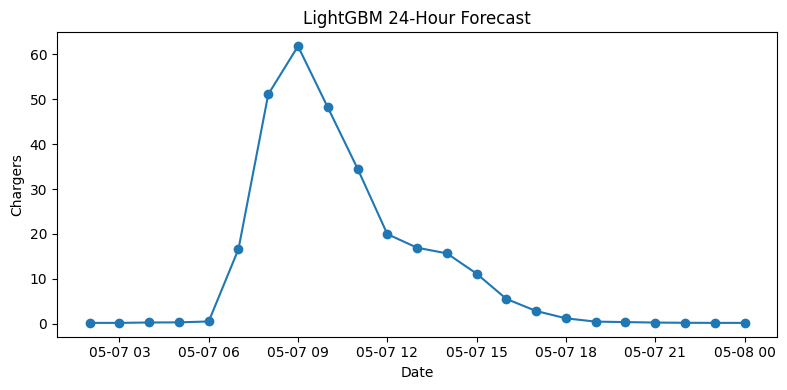

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 8039, number of used features: 4
[LightGBM] [Info] Start training from score 10.079439

--- Backtest Metrics (Last 30 Days) ---
MAE:  4.22
RMSE: 9.99
R2:   0.83


C:\Users\user\AppData\Local\Temp\ipykernel_18200\1158969930.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bt['yhat'] = lgbm_bt.predict(X_test_bt)


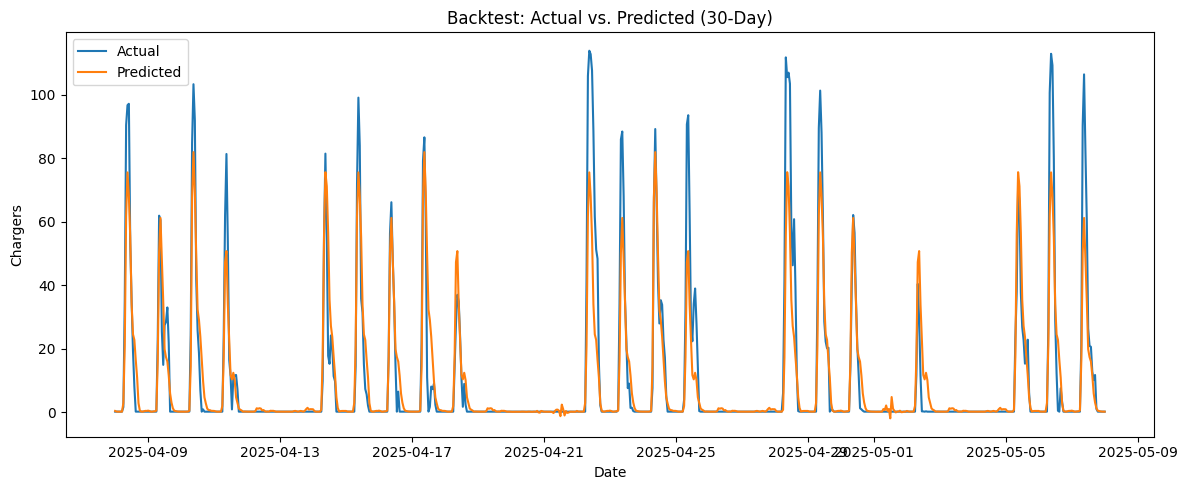

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Load & preprocess ---
df = pd.read_csv("./Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds')
df = df.rename(columns={"Chargers": "y"})

# --- 2. Feature engineering ---
df['weekday']       = df['ds'].dt.weekday
df['hour']          = df['ds'].dt.hour
df['is_weekend']    = (df['weekday'] >= 5).astype(int)
df['is_work_hour']  = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# avg consumption by weekday & hour
avg_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'avg_hourly_by_weekday'})
)
df = df.merge(avg_map, on=['weekday','hour'], how='left')

# holiday flag for Belgium
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())
df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# --- 3. Define windows ---
latest = df['ds'].max()
start_forecast = latest - pd.Timedelta(hours=23)
start_backtest = latest - pd.Timedelta(days=30)

# Feature list
FEATURES = [
    'is_weekend',
    'is_work_hour',
    'avg_hourly_by_weekday',
    'is_holiday'
]

# --- 4. Forecast last 24h with LightGBM ---
# train on everything before start_forecast
train_f = df[df['ds'] < start_forecast]
X_train_f = train_f[FEATURES]
y_train_f = train_f['y']

# train model
lgbm_f = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
lgbm_f.fit(X_train_f, y_train_f)

# prepare 24h-out features
future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
                           end=latest, freq='H')
future_df = pd.DataFrame({'ds': future_idx})
future_df['weekday']      = future_df['ds'].dt.weekday
future_df['hour']         = future_df['ds'].dt.hour
future_df['is_weekend']   = (future_df['weekday'] >= 5).astype(int)
future_df['is_work_hour'] = ((future_df['hour'] >= 8) & (future_df['hour'] <= 18)).astype(int)
future_df = future_df.merge(avg_map, on=['weekday','hour'], how='left')
future_df['is_holiday']   = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)

# predict
future_df['yhat'] = lgbm_f.predict(future_df[FEATURES])
print("\n--- 24h Forecast ---")
print(future_df[['ds','yhat']])

# plot
plt.figure(figsize=(8,4))
plt.plot(future_df['ds'], future_df['yhat'], '-o')
plt.title("LightGBM 24-Hour Forecast")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.tight_layout()
plt.show()


# --- 5. Backtest last 30 days ---
# train on before start_backtest, test on >=
train_bt = df[df['ds'] < start_backtest]
test_bt  = df[df['ds'] >= start_backtest]

X_train_bt = train_bt[FEATURES]
y_train_bt = train_bt['y']
X_test_bt  = test_bt[FEATURES]
y_test_bt  = test_bt['y']

lgbm_bt = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05)
lgbm_bt.fit(X_train_bt, y_train_bt)

test_bt['yhat'] = lgbm_bt.predict(X_test_bt)

# metrics
mae  = mean_absolute_error(y_test_bt, test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(y_test_bt, test_bt['yhat']))
r2   = r2_score(y_test_bt, test_bt['yhat'])

print("\n--- Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")

# plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], y_test_bt,    label='Actual')
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted')
plt.title("Backtest: Actual vs. Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_18200\2635853480.py:41: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 8734, number of used features: 5
[LightGBM] [Info] Start training from score 10.096655

--- 24-Hour Forecast ---
                    ds  yhat
0  2025-05-07 00:00:00  0.39
1  2025-05-07 01:00:00  0.35
2  2025-05-07 02:00:00  0.16
3  2025-05-07 03:00:00  0.16
4  2025-05-07 04:00:00  0.23
5  2025-05-07 05:00:00  0.27
6  2025-05-07 06:00:00  0.41
7  2025-05-07 07:00:00 16.31
8  2025-05-07 08:00:00 50.27
9  2025-05-07 09:00:00 61.23
10 2025-05-07 10:00:00 47.21
11 2025-05-07 11:00:00 33.49
12 2025-05-07 12:00:00 18.83
13 2025-05-07 13:00:00 16.15
14 2025-05-07 14:00:00 14.98
15 2025-05-07 15:00:00 11.12
16 2025-05-07 16:00:00  5.44
17 2025-05-07 17:00:00  2.65
18 2025-05-07 18:00

C:\Users\user\AppData\Local\Temp\ipykernel_18200\2635853480.py:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
C:\Users\user\AppData\Local\Temp\ipykernel_18200\2635853480.py:77: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_df['is_holiday']      = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)


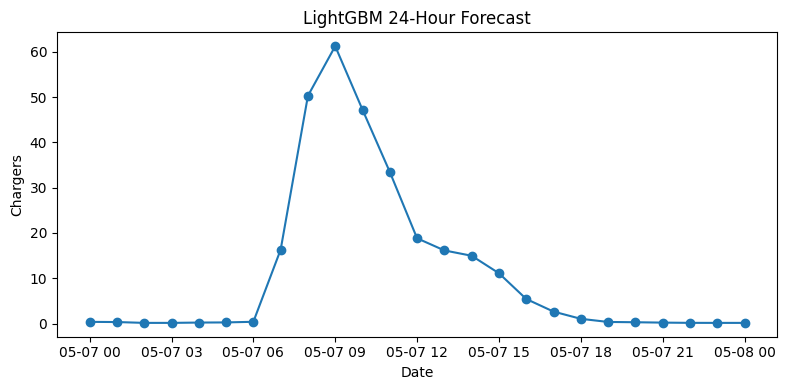

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 8039, number of used features: 5
[LightGBM] [Info] Start training from score 10.079439

--- Backtest Metrics (Last 30 Days) ---
MAE:  4.06
RMSE: 9.40
R2:   0.85


C:\Users\user\AppData\Local\Temp\ipykernel_18200\2635853480.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bt['yhat'] = model_bt.predict(X_test_bt)


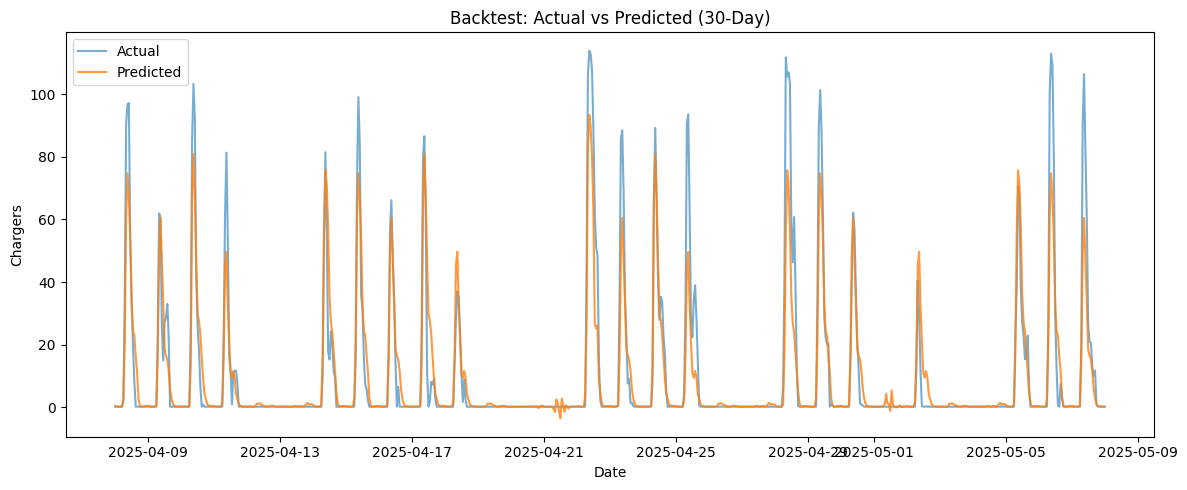

In [35]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Load & preprocess data ---
df = pd.read_csv("./Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={"Chargers": "y"})

# --- 2. Define “terugkomdagen” (mandatory in-office days) ---
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)

# --- 3. Feature engineering ---
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# Avg consumption by weekday & hour
avg_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'avg_hourly_by_weekday'})
)
df = df.merge(avg_map, on=['weekday','hour'], how='left')

# Holiday flag for Belgium
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())
df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# --- 4. Define windows & feature list ---
latest         = df['ds'].max()
start_forecast = latest - pd.Timedelta(hours=25)
start_backtest = latest - pd.Timedelta(days=30)

FEATURES = [
    'is_weekend',
    'is_work_hour',
    'avg_hourly_by_weekday',
    'is_holiday',
    'is_terugkomdag'
]

# --- 5. 24-Hour Forecast with LightGBM ---
train_f = df[df['ds'] < start_forecast]
X_train_f = train_f[FEATURES]
y_train_f = train_f['y']

model_f = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
model_f.fit(X_train_f, y_train_f)

# prepare next 24h features
future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
                           end=latest, freq='H')
future_df = pd.DataFrame({'ds': future_idx})
future_df['weekday']      = future_df['ds'].dt.weekday
future_df['hour']         = future_df['ds'].dt.hour
future_df['is_weekend']   = (future_df['weekday'] >= 5).astype(int)
future_df['is_work_hour'] = ((future_df['hour'] >= 8) & (future_df['hour'] <= 18)).astype(int)
future_df = future_df.merge(avg_map, on=['weekday','hour'], how='left')
future_df['is_holiday']      = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)
future_df['is_terugkomdag']  = future_df['ds'].dt.normalize().isin(tkd).astype(int)

future_df['yhat'] = model_f.predict(future_df[FEATURES])
print("\n--- 24-Hour Forecast ---")
print(future_df[['ds','yhat']])

plt.figure(figsize=(8,4))
plt.plot(future_df['ds'], future_df['yhat'], '-o')
plt.title("LightGBM 24-Hour Forecast")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.tight_layout()
plt.show()

# --- 6. Backtest Last 30 Days (single-shot) ---
train_bt = df[df['ds'] < start_backtest]
test_bt  = df[df['ds'] >= start_backtest]

X_train_bt = train_bt[FEATURES]
y_train_bt = train_bt['y']
X_test_bt  = test_bt[FEATURES]
y_test_bt  = test_bt['y']

model_bt = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)
model_bt.fit(X_train_bt, y_train_bt)

test_bt['yhat'] = model_bt.predict(X_test_bt)

mae  = mean_absolute_error(y_test_bt, test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(y_test_bt, test_bt['yhat']))
r2   = r2_score(y_test_bt, test_bt['yhat'])

print("\n--- Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")

plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], y_test_bt,      label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Backtest: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_18200\102597781.py:41: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 8736, number of used features: 6
[LightGBM] [Info] Start training from score 10.094380

--- 24-Hour Forecast ---
                    ds  yhat
0  2025-05-07 02:00:00  0.17
1  2025-05-07 03:00:00  0.17
2  2025-05-07 04:00:00  0.20
3  2025-05-07 05:00:00  0.31
4  2025-05-07 06:00:00  0.46
5  2025-05-07 07:00:00 14.52
6  2025-05-07 08:00:00 53.45
7  2025-05-07 09:00:00 63.92
8  2025-05-07 10:00:00 70.52
9  2025-05-07 11:00:00 53.56
10 2025-05-07 12:00:00 18.25
11 2025-05-07 13:00:00 17.58
12 2025-05-07 14:00:00 11.02
13 2025-05-07 15:00:00  6.87
14 2025-05-07 16:00:00  4.83
15 2025-05-07 17:00:00  2.56
16 2025-05-07 18:00:00  0.83
17 2025-05-07 19:00:00  0.33
18 2025-05-07 20:00

C:\Users\user\AppData\Local\Temp\ipykernel_18200\102597781.py:70: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
C:\Users\user\AppData\Local\Temp\ipykernel_18200\102597781.py:78: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_df['is_holiday']     = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)


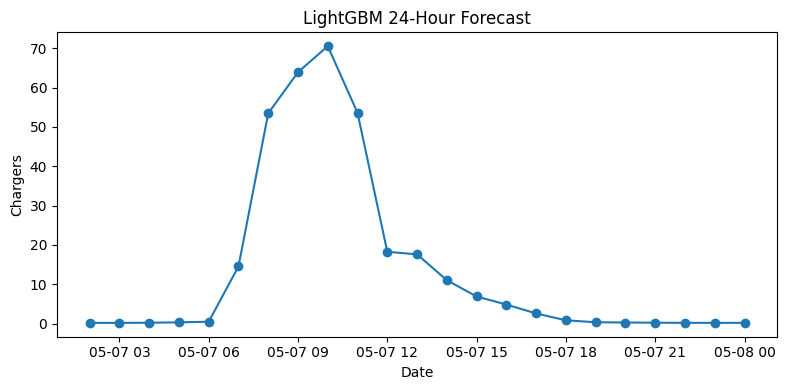

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 8039, number of used features: 6
[LightGBM] [Info] Start training from score 10.079439


C:\Users\user\AppData\Local\Temp\ipykernel_18200\102597781.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_bt['yhat'] = model_bt.predict(X_test_bt)



--- Backtest Metrics (Last 30 Days) ---
MAE:  4.42
RMSE: 9.68
R2:   0.84


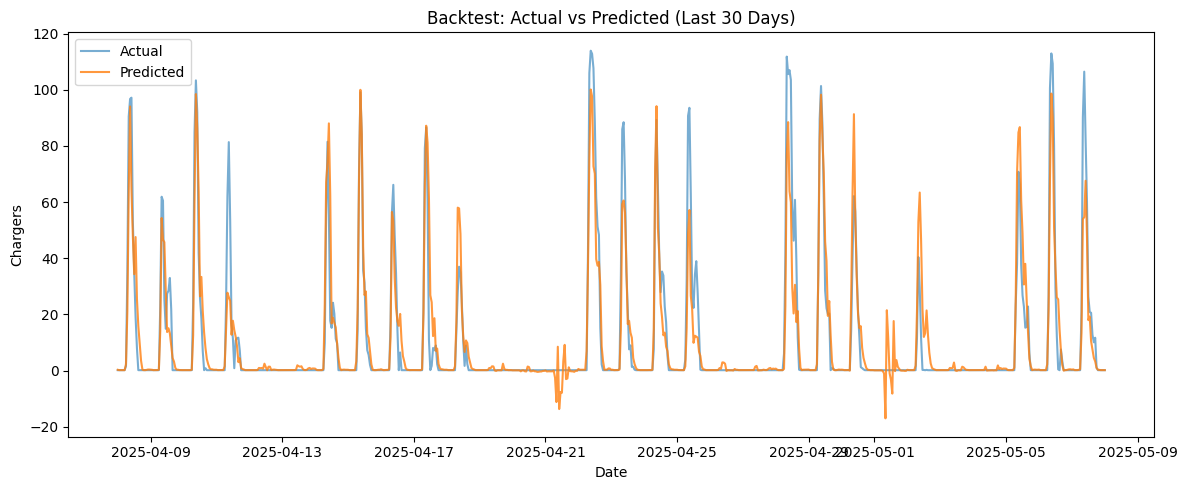

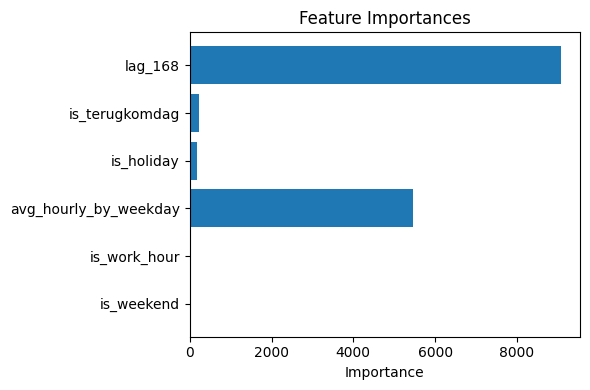

In [38]:
import pandas as pd
import numpy as np
import holidays
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Load & preprocess data ---
df = pd.read_csv("./Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={"Chargers": "y"})

# --- 2. Define “terugkomdagen” (mandatory in-office days) ---
terugkomdagen = [
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]
tkd = pd.to_datetime(terugkomdagen).normalize()
df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)

# --- 3. Feature engineering ---
df['weekday']       = df['ds'].dt.weekday
df['hour']          = df['ds'].dt.hour
df['is_weekend']    = (df['weekday'] >= 5).astype(int)
df['is_work_hour']  = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

# avg consumption by weekday & hour
avg_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'avg_hourly_by_weekday'})
)
df = df.merge(avg_map, on=['weekday','hour'], how='left')

# holiday flag for Belgium
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())
df['is_holiday'] = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# historical weekly lag: value 168 hours ago
df['lag_168'] = df['y'].shift(168)
df['lag_168'] = df['lag_168'].fillna(df['avg_hourly_by_weekday'])

# --- 4. Define windows & feature list ---
latest         = df['ds'].max()
start_forecast = latest - pd.Timedelta(hours=23)
start_backtest = latest - pd.Timedelta(days=30)

FEATURES = [
    'is_weekend',
    'is_work_hour',
    'avg_hourly_by_weekday',
    'is_holiday',
    'is_terugkomdag',
    'lag_168'
]

# --- 5. 24-Hour Forecast with LightGBM ---
train_f = df[df['ds'] < start_forecast]
X_train_f = train_f[FEATURES]
y_train_f = train_f['y']

model_f = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model_f.fit(X_train_f, y_train_f)

# prepare next 24 h features
future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
                           end=latest, freq='H')
future_df = pd.DataFrame({'ds': future_idx})
future_df['weekday']      = future_df['ds'].dt.weekday
future_df['hour']         = future_df['ds'].dt.hour
future_df['is_weekend']   = (future_df['weekday'] >= 5).astype(int)
future_df['is_work_hour'] = ((future_df['hour'] >= 8) & (future_df['hour'] <= 18)).astype(int)
future_df = future_df.merge(avg_map, on=['weekday','hour'], how='left')
future_df['is_holiday']     = future_df['ds'].dt.normalize().isin(be_holidays).astype(int)
future_df['is_terugkomdag'] = future_df['ds'].dt.normalize().isin(tkd).astype(int)

# build a shifted DataFrame for lag_168 and merge
lag_df = df[['ds','y']].copy()
lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)    # shift forward 7 days
lag_df = lag_df.rename(columns={'y':'lag_168'})
future_df = future_df.merge(lag_df, on='ds', how='left')
future_df['lag_168'] = future_df['lag_168'].fillna(future_df['avg_hourly_by_weekday'])

# predict
future_df['yhat'] = model_f.predict(future_df[FEATURES])

print("\n--- 24-Hour Forecast ---")
print(future_df[['ds','yhat']])

plt.figure(figsize=(8,4))
plt.plot(future_df['ds'], future_df['yhat'], '-o')
plt.title("LightGBM 24-Hour Forecast")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.tight_layout()
plt.show()

# --- 6. Backtest Last 30 Days (single-shot) ---
train_bt = df[df['ds'] < start_backtest]
test_bt  = df[df['ds'] >= start_backtest]

X_train_bt = train_bt[FEATURES]
y_train_bt = train_bt['y']
X_test_bt  = test_bt[FEATURES]
y_test_bt  = test_bt['y']

model_bt = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model_bt.fit(X_train_bt, y_train_bt)

test_bt['yhat'] = model_bt.predict(X_test_bt)

mae  = mean_absolute_error(y_test_bt, test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(y_test_bt, test_bt['yhat']))
r2   = r2_score(y_test_bt, test_bt['yhat'])

print("\n--- Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.2f}")

plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], y_test_bt,       label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Backtest: Actual vs Predicted (Last 30 Days)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout()
plt.show()

# --- 7. Feature importance plot ---
importances = model_bt.feature_importances_
plt.figure(figsize=(6,4))
plt.barh(FEATURES, importances)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_8732\579823090.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),



--- 24-Hour Baseline Forecast ---
                    ds  y_baseline
0  2025-05-07 02:00:00    0.152528
1  2025-05-07 03:00:00    0.152321
2  2025-05-07 04:00:00    0.233377
3  2025-05-07 05:00:00    0.264245
4  2025-05-07 06:00:00    0.453943
5  2025-05-07 07:00:00   16.074792
6  2025-05-07 08:00:00   49.920962
7  2025-05-07 09:00:00   60.380811
8  2025-05-07 10:00:00   47.035019
9  2025-05-07 11:00:00   33.741472
10 2025-05-07 12:00:00   19.321264
11 2025-05-07 13:00:00   16.359755
12 2025-05-07 14:00:00   15.168057
13 2025-05-07 15:00:00   10.741057
14 2025-05-07 16:00:00    5.380075
15 2025-05-07 17:00:00    2.872250
16 2025-05-07 18:00:00    1.131623
17 2025-05-07 19:00:00    0.423868
18 2025-05-07 20:00:00    0.318491
19 2025-05-07 21:00:00    0.223321
20 2025-05-07 22:00:00    0.173245
21 2025-05-07 23:00:00    0.154717
22 2025-05-08 00:00:00    0.152698


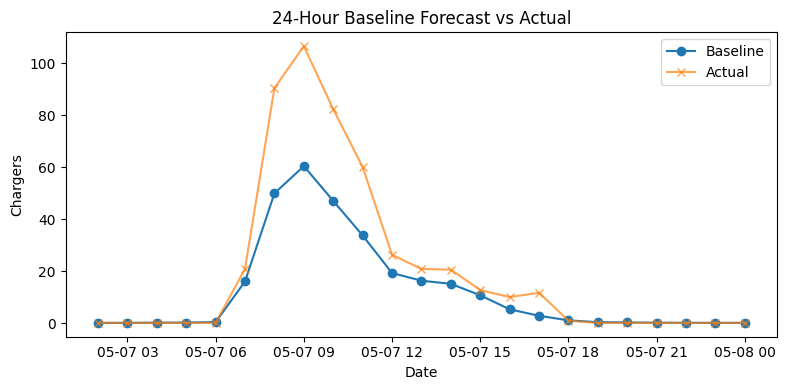


--- Baseline Backtest Metrics (Last 30 Days) ---
MAE:  5.15
RMSE: 12.20
R²:   0.74


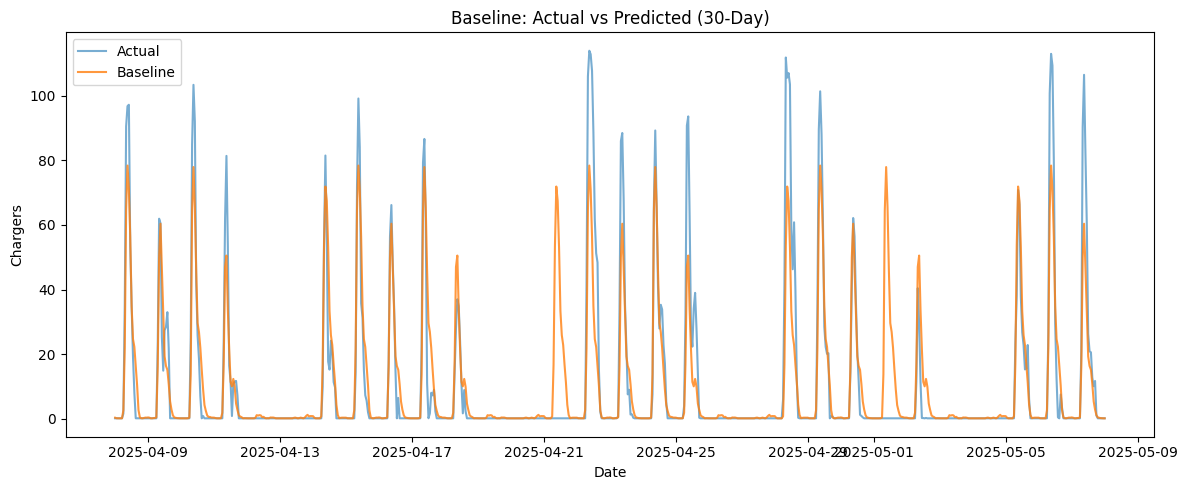

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load & preprocess
df = pd.read_csv("./Charging_data_cleaned.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={"Chargers": "y"})

# 2. Compute baseline mean by weekday & hour
df['weekday'] = df['ds'].dt.weekday
df['hour']    = df['ds'].dt.hour

baseline_map = (
    df.groupby(['weekday','hour'])['y']
      .mean()
      .reset_index()
      .rename(columns={'y':'y_baseline'})
)

# Merge baseline back into full df
df = df.merge(baseline_map, on=['weekday','hour'], how='left')

# 3. Define forecast & backtest windows
latest         = df['ds'].max()
start_forecast = latest - pd.Timedelta(hours=23)
start_backtest = latest - pd.Timedelta(days=30)

# 4. 24-Hour Baseline Forecast
future_idx = pd.date_range(start=start_forecast + pd.Timedelta(hours=1),
                           end=latest, freq='H')
future_df = pd.DataFrame({'ds': future_idx})
future_df['weekday']    = future_df['ds'].dt.weekday
future_df['hour']       = future_df['ds'].dt.hour
future_df = future_df.merge(baseline_map, on=['weekday','hour'], how='left')

print("\n--- 24-Hour Baseline Forecast ---")
print(future_df[['ds','y_baseline']])

# Plot 24h baseline
plt.figure(figsize=(8,4))
plt.plot(future_df['ds'], future_df['y_baseline'], '-o', label='Baseline')
# overlay actual
actual_24h = df[df['ds'] > start_forecast][['ds','y']]
plt.plot(actual_24h['ds'], actual_24h['y'], '-x', label='Actual', alpha=0.7)
plt.title("24-Hour Baseline Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()

# 5. Backtest Last 30 Days
test_bt   = df[df['ds'] >= start_backtest]
y_true_bt = test_bt['y']
y_pred_bt = test_bt['y_baseline']

mae  = mean_absolute_error(y_true_bt, y_pred_bt)
rmse = np.sqrt(mean_squared_error(y_true_bt, y_pred_bt))
r2   = r2_score(y_true_bt, y_pred_bt)

print("\n--- Baseline Backtest Metrics (Last 30 Days) ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

# Plot backtest
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], y_true_bt,    label='Actual', alpha=0.6)
plt.plot(test_bt['ds'], y_pred_bt,    label='Baseline', alpha=0.8)
plt.title("Baseline: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()
